In [ ]:
# from huggingface_hub import login
# login("")

In [6]:
from datasets import load_dataset

dataset = load_dataset("jason23322/high-accuracy-email-classifier")
print(dataset)

train.json:   0%|          | 0.00/4.15M [00:00<?, ?B/s]

test.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'subject', 'body', 'text', 'category', 'category_id'],
        num_rows: 10780
    })
    test: Dataset({
        features: ['id', 'subject', 'body', 'text', 'category', 'category_id'],
        num_rows: 2697
    })
})


In [7]:
# Importy bibliotek do analizy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Pobieranie zasobów NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

# Ustawienia wizualizacji
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Krzychu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Krzychu\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Krzychu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Krzychu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Eksploracja Danych Tekstowych - Klasyfikacja Emaili

## 1. Wczytanie i przegląd danych

In [8]:
df = pd.concat([
    dataset['train'].to_pandas(),
    dataset['test'].to_pandas()
])

# Podgląd struktury danych
print(f"Rozmiar datasetu: {len(df)} emaili")
print(f"\nKolumny: {list(df.columns)}")
print(f"\nPierwsze 5 wierszy:")
df.head()

Rozmiar datasetu: 13477 emaili

Kolumny: ['id', 'subject', 'body', 'text', 'category', 'category_id']

Pierwsze 5 wierszy:


,id,subject,body,text,category,category_id
0,promotions_582,Anniversary Special: Buy one get one free,"As our loyal customer, get exclusive $60 off $...",Anniversary Special: Buy one get one free As o...,promotions,1
1,spam_1629,Your Amazon was used on new device,Your $5000 refund is processed. Claim: bit.ly/...,Your Amazon was used on new device Your $5000 ...,spam,3
2,spam_322,Re: Your Google inquiry,"Hi, following up about your Google application...","Re: Your Google inquiry Hi, following up about...",spam,3
3,social_media_80,Digital Ritual Experience Creation,Cross-cultural ceremony design. Join: virtualr...,Digital Ritual Experience Creation Cross-cultu...,social_media,2
4,forum_1351,"Your post was moved to ""Programming Help""","Trending: ""cooking"" (258 comments). View: supp...","Your post was moved to ""Programming Help"" Tren...",forum,0


In [9]:
print("📈 Podstawowe statystyki tekstowe:\n")
print(df.info())
print("\n")
print("\n🔢 Brakujące wartości:")
print(df.isnull().sum())
print("\n" + "="*50)
print("\nPrzykładowy email (Spam):")
sample_spam = df[df['category'] == 'spam'].iloc[0]
print(f"\nTemat: {sample_spam['subject']}")
print(f"Treść: {sample_spam['body'][:300]}...")

📈 Podstawowe statystyki tekstowe:

<class 'pandas.core.frame.DataFrame'>
Index: 13477 entries, 0 to 2696
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           13477 non-null  object
 1   subject      13477 non-null  object
 2   body         13477 non-null  object
 3   text         13477 non-null  object
 4   category     13477 non-null  object
 5   category_id  13477 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 737.0+ KB
None



🔢 Brakujące wartości:
id             0
subject        0
body           0
text           0
category       0
category_id    0
dtype: int64


Przykładowy email (Spam):

Temat: Your Amazon was used on new device
Treść: Your $5000 refund is processed. Claim: bit.ly/fakeprize Complete within 48hrshrs....


---
## 2. Tłumaczenie zbioru na język polski

In [10]:
# Instalacja bibliotek do tłumaczenia i polskiego NLP
!pip install deep-translator spacy -q
!python -m spacy download pl_core_news_sm -q

  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.7.2 which is incompatible.
matplotlib 3.7.5 requires numpy<2,>=1.20, but you have numpy 2.4.1 which is incompatible.
numba 0.61.2 requires numpy<2.3,>=1.24, but you have numpy 2.4.1 which is incompatible.
pandas 2.1.4 requires numpy<2,>=1.23.2; python_version == "3.11", but you have numpy 2.4.1 which is incompatible.
pycaret 3.3.2 requires numpy<1.27,>=1.21, but you have numpy 2.4.1 which is incompatible.
scipy 1.11.4 requires numpy<1.28.0,>=1.21.6, but you have numpy 2.4.1 which is incompatible.
sktime 0.26.0 requires numpy<1.27,>=1.21, but you have numpy 2.4.1 which is incompatible.
sktime 0.26.0 requires scikit-learn<1.5.0,>=0.24, but you have scikit-

✔ Download and installation successful
You can now load the package via spacy.load('pl_core_news_sm')


In [11]:
from deep_translator import GoogleTranslator
import spacy
from tqdm import tqdm
import os
from concurrent.futures import ThreadPoolExecutor, as_completed
import time

# Wczytanie modelu polskiego spaCy
nlp_pl = spacy.load('pl_core_news_sm')

def translate_batch(texts, src='en', dest='pl', batch_size=10):
    translator = GoogleTranslator(source=src, target=dest)
    results = []

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        # Przygotuj teksty (usuń puste, skróć długie)
        batch_clean = []
        for t in batch:
            if pd.isna(t) or str(t).strip() == '':
                batch_clean.append('')
            else:
                batch_clean.append(str(t)[:4500])

        try:
            # Tłumaczenie całego batcha naraz
            translated = translator.translate_batch(batch_clean)
            results.extend(translated)
        except Exception as e:
            # Fallback - tłumacz pojedynczo
            for t in batch_clean:
                try:
                    if t == '':
                        results.append('')
                    else:
                        results.append(translator.translate(t) or t)
                except:
                    results.append(t)
            time.sleep(0.5)

    return results

def translate_dataframe_fast(df, columns_to_translate, csv_file):
    # Sprawdź czy plik CSV już istnieje
    if os.path.exists(csv_file):
        print(f"Wczytywanie przetłumaczonego zbioru z: {csv_file}")
        return pd.read_csv(csv_file)

    df_translated = df.copy()

    for col in columns_to_translate:
        if col in df.columns:
            print(f"\nTłumaczenie kolumny '{col}' ({len(df)} wierszy)...")
            texts = df[col].tolist()

            # Podziel na większe chunki dla progress bar
            chunk_size = 500
            all_translated = []

            for i in tqdm(range(0, len(texts), chunk_size), desc=f"Tłumaczenie {col}"):
                chunk = texts[i:i+chunk_size]
                translated_chunk = translate_batch(chunk, batch_size=10)
                all_translated.extend(translated_chunk)
                time.sleep(0.2)  # Mała przerwa żeby nie przekroczyć limitu API

            df_translated[col] = all_translated

    # Zapisz do CSV
    print(f"\nZapisywanie do: {csv_file}")
    df_translated.to_csv(csv_file, index=False)

    return df_translated

In [12]:
CSV_FILE = 'emails_polish.csv'

df_pl = translate_dataframe_fast(
    df,
    columns_to_translate=['subject', 'body', 'text'],
    csv_file=CSV_FILE
)

print(f"Zbiór oryginalny: {len(df)} emaili")
print(f"Zbiór przetłumaczony: {len(df_pl)} emaili")
print(f"📁 Plik CSV: {CSV_FILE}")

Wczytywanie przetłumaczonego zbioru z: emails_polish.csv
Zbiór oryginalny: 13477 emaili
Zbiór przetłumaczony: 13477 emaili
📁 Plik CSV: emails_polish.csv


## end translation

### Jeśli już przetłumaczone:

In [13]:
!python -m spacy download pl_core_news_sm -q

✔ Download and installation successful
You can now load the package via spacy.load('pl_core_news_sm')


In [14]:
CSV_FILE = 'emails_polish.csv'
df_pl = pd.read_csv(CSV_FILE)

import spacy
nlp_pl = spacy.load('pl_core_news_sm')

In [15]:
# Podgląd tłumaczeń
print("="*70)
print("PRZYKŁADOWE TŁUMACZENIA")
print("="*70)

for i in range(3):
    print(f"\n{'─'*70}")
    print(f"Email {i+1} | Kategoria: {df.iloc[i]['category']}")
    print(f"{'─'*70}")
    print(f"🇬🇧 Temat EN: {df.iloc[i]['subject']}")
    print(f"🇵🇱 Temat PL: {df_pl.iloc[i]['subject']}")
    print(f"\n🇬🇧 Treść EN: {str(df.iloc[i]['text'])[:150]}...")
    print(f"🇵🇱 Treść PL: {str(df_pl.iloc[i]['text'])[:150]}...")

PRZYKŁADOWE TŁUMACZENIA

──────────────────────────────────────────────────────────────────────
Email 1 | Kategoria: promotions
──────────────────────────────────────────────────────────────────────
🇬🇧 Temat EN: Anniversary Special: Buy one get one free
🇵🇱 Temat PL: Oferta rocznicowa: kup jeden, drugi otrzymasz gratis

🇬🇧 Treść EN: Anniversary Special: Buy one get one free As our loyal customer, get exclusive $60 off $75+: example.com/6058 Offer code: WELCOME20....
🇵🇱 Treść PL: Oferta rocznicowa: kup jeden, drugi otrzymasz gratis Jako nasz lojalny klient uzyskaj ekskluzywną zniżkę 60 USD na kwotę 75 USD i więcej: example.com/...

──────────────────────────────────────────────────────────────────────
Email 2 | Kategoria: spam
──────────────────────────────────────────────────────────────────────
🇬🇧 Temat EN: Your Amazon was used on new device
🇵🇱 Temat PL: Twój Amazon był używany na nowym urządzeniu

🇬🇧 Treść EN: Your Amazon was used on new device Your $5000 refund is processed. Claim: b

## 2. Analiza rozkładu kategorii

Sprawdźmy jak wyglądają proporcje emaili w poszczególnych kategoriach:

C:\Users\Krzychu\AppData\Local\Temp\ipykernel_160184\1278447642.py:23: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
C:\Users\Krzychu\AppData\Local\Temp\ipykernel_160184\1278447642.py:23: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\Krzychu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Krzychu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


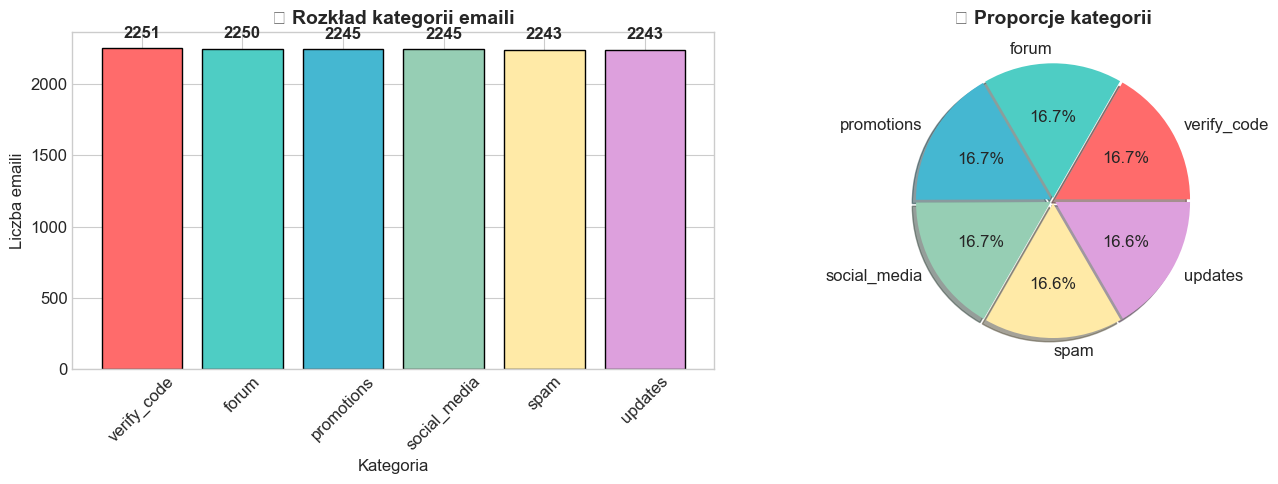


📋 Statystyki kategorii:
              Liczba
category            
verify_code     2251
forum           2250
promotions      2245
social_media    2245
spam            2243
updates         2243


In [16]:
# Rozkład kategorii
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Wykres słupkowy
category_counts = df['category'].value_counts()
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD']
bars = axes[0].bar(category_counts.index, category_counts.values, color=colors, edgecolor='black')
axes[0].set_title('📊 Rozkład kategorii emaili', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Kategoria')
axes[0].set_ylabel('Liczba emaili')
axes[0].tick_params(axis='x', rotation=45)

# Dodanie wartości na słupkach
for bar, count in zip(bars, category_counts.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
                 str(count), ha='center', va='bottom', fontweight='bold')

# Wykres kołowy
axes[1].pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%',
            colors=colors, explode=[0.02]*len(category_counts), shadow=True)
axes[1].set_title('📈 Proporcje kategorii', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n📋 Statystyki kategorii:")
print(category_counts.to_frame().rename(columns={'count': 'Liczba'}))

## 3. Analiza długości tekstów

Sprawdzimy jak długie są emaile w poszczególnych kategoriach (liczba znaków i słów):

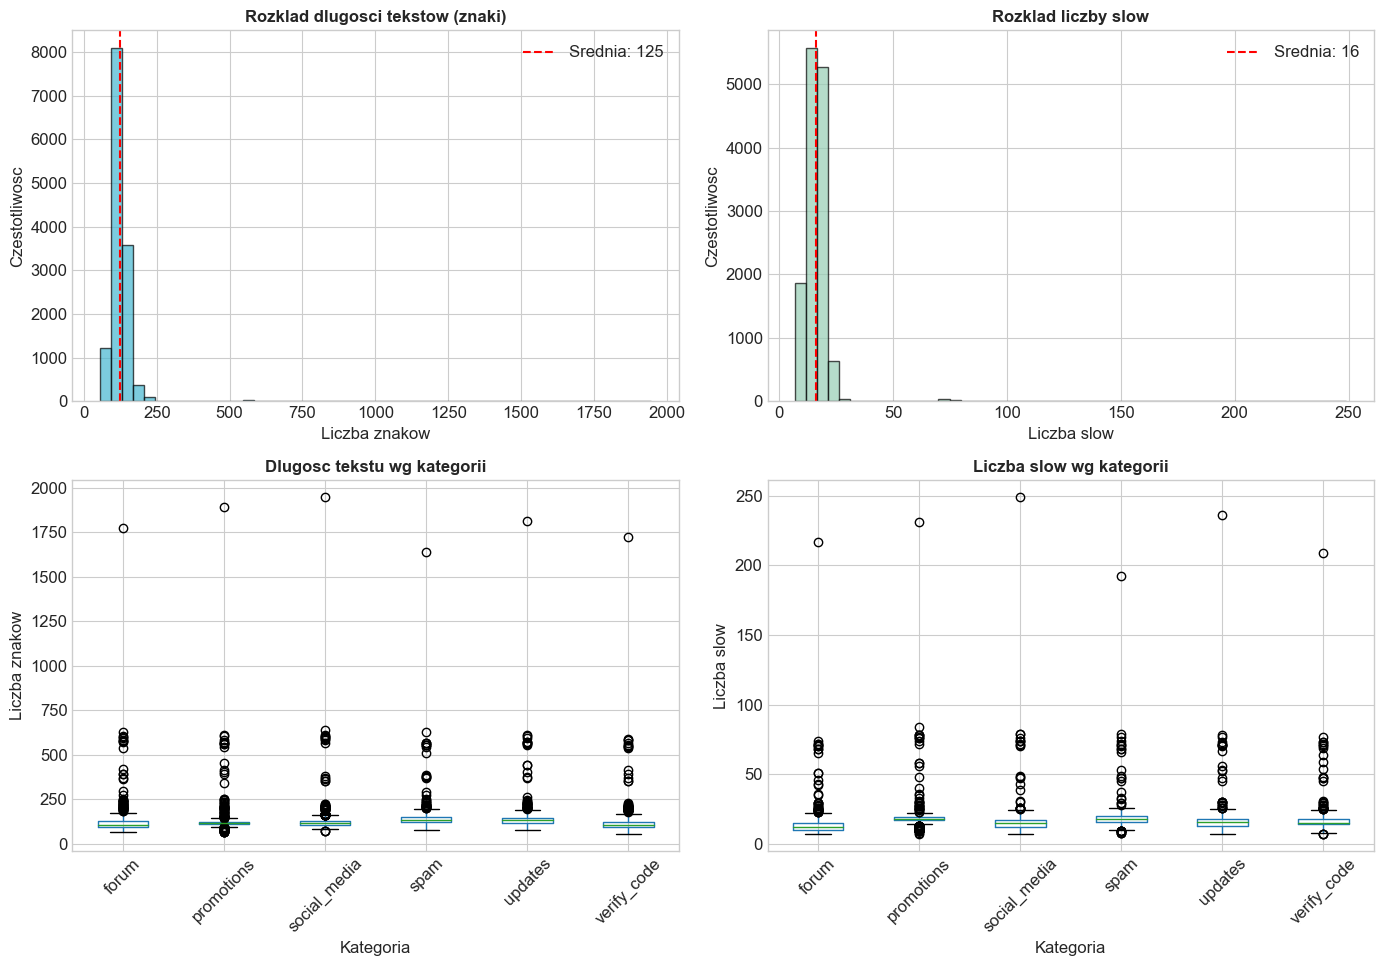


Statystyki długości tekstów per kategoria:
             text_length                  word_count               
                    mean min   max    std       mean min  max   std
category                                                           
forum             116.14  66  1771  55.26      13.20   7  217  6.78
promotions        122.82  65  1890  51.22      18.11   7  231  6.48
social_media      124.51  74  1947  53.66      15.00   7  249  7.03
spam              139.62  78  1636  48.54      18.33   8  192  6.29
updates           134.87  77  1811  52.80      16.22   7  236  7.05
verify_code       113.40  55  1725  51.69      15.88   7  209  6.30


In [17]:
# Dodanie kolumn z długościami
df['text_length'] = df['text'].apply(len)
df['word_count'] = df['text'].apply(lambda x: len(x.split()))
df['subject_length'] = df['subject'].apply(len)

# Wykresy rozkładu długości
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histogram długości tekstu
axes[0, 0].hist(df['text_length'], bins=50, color='#45B7D1', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Rozklad dlugosci tekstow (znaki)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Liczba znakow')
axes[0, 0].set_ylabel('Czestotliwosc')
axes[0, 0].axvline(df['text_length'].mean(), color='red', linestyle='--', label=f'Srednia: {df["text_length"].mean():.0f}')
axes[0, 0].legend()

# Histogram liczby słów
axes[0, 1].hist(df['word_count'], bins=50, color='#96CEB4', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Rozklad liczby slow', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Liczba slow')
axes[0, 1].set_ylabel('Czestotliwosc')
axes[0, 1].axvline(df['word_count'].mean(), color='red', linestyle='--', label=f'Srednia: {df["word_count"].mean():.0f}')
axes[0, 1].legend()

# Boxplot długości per kategoria
df.boxplot(column='text_length', by='category', ax=axes[1, 0])
axes[1, 0].set_title('Dlugosc tekstu wg kategorii', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Kategoria')
axes[1, 0].set_ylabel('Liczba znakow')
plt.suptitle('')
axes[1, 0].tick_params(axis='x', rotation=45)

# Boxplot słów per kategoria
df.boxplot(column='word_count', by='category', ax=axes[1, 1])
axes[1, 1].set_title('Liczba slow wg kategorii', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Kategoria')
axes[1, 1].set_ylabel('Liczba slow')
plt.suptitle('')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Statystyki
print("\nStatystyki długości tekstów per kategoria:")
print(df.groupby('category')[['text_length', 'word_count']].agg(['mean', 'min', 'max', 'std']).round(2))

## 4. Preprocessing tekstu (Angielski 🇬🇧 i Polski 🇵🇱)

Przygotowanie tekstu do analizy dla obu języków:
- Usunięcie znaków specjalnych i cyfr
- Zamiana na małe litery
- Tokenizacja
- Usunięcie stop words
- Lematyzacja

In [18]:
stop_words_en = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Polskie stop words
stop_words_pl = {
    'i', 'w', 'z', 'na', 'do', 'o', 'się', 'nie', 'to', 'jest', 'że', 'a',
    'co', 'jak', 'za', 'od', 'po', 'ale', 'czy', 'tak', 'są', 'my', 'wy',
    'on', 'ona', 'ono', 'oni', 'one', 'ja', 'ty', 'mu', 'go', 'jej', 'ich',
    'mi', 'mnie', 'cię', 'ci', 'was', 'nam', 'wam', 'im', 'niego', 'niej',
    'tego', 'tej', 'tym', 'tych', 'tym', 'temu', 'tą', 'te', 'ta', 'tę',
    'ze', 'przez', 'dla', 'przy', 'pod', 'nad', 'przed', 'między', 'bez',
    'będzie', 'został', 'została', 'zostało', 'może', 'mogą', 'można',
    'kiedy', 'gdzie', 'gdy', 'lub', 'oraz', 'albo', 'ani', 'więc', 'jednak',
    'także', 'również', 'właśnie', 'bowiem', 'ponieważ', 'gdyż', 'aby',
    'żeby', 'sobie', 'siebie', 'sobą', 'jako', 'który', 'która', 'które',
    'których', 'którym', 'którą', 'których', 'czym', 'kto', 'kim', 'komu',
    'być', 'mieć', 'móc', 'chcieć', 'zostać', 'ten', 'bardzo', 'też',
    'tylko', 'jeszcze', 'już', 'teraz', 'tutaj', 'tam', 'tu', 'wszystko',
    'wszystkie', 'wszystkich', 'każdy', 'każda', 'każde', 'każdego',
    'jakiś', 'jakaś', 'jakieś', 'jakichś', 'coś', 'ktoś', 'nic', 'nikt',
    'zawsze', 'nigdy', 'często', 'rzadko', 'czasem', 'potem', 'teraz',
    'wcześniej', 'później', 'dzisiaj', 'jutro', 'wczoraj', 'roku', 'lat'
}


# wzorzec regex na linki, domeny i ścieżki (np. domena.pl/sciezka)
# 1. Wykrywa protokoły (http/https/www)
# 2. Wykrywa ciągi znaków z kropką w środku i ukośnikami (typowy adres/ścieżka)
URL_PATH_PATTERN = r'(https?://\S+|www\.\S+|\b[a-zA-Z0-9.-]+\.[a-zA-Z]{2,6}(?:/\S*)?\b)'

def clean_raw_noise(text):
    """Wspólna funkcja usuwająca śmieci (linki, maile, ścieżki) przed tokenizacją"""
    if pd.isna(text):
        return ''
    text = str(text).lower()
    # 1. Usuwanie linków i ścieżek URL (zmieniona kolejność - to musi być pierwsze!)
    text = re.sub(URL_PATH_PATTERN, '', text)
    # 2. Usuwanie adresów e-mail
    text = re.sub(r'\S+@\S+', '', text)
    # 3. Usuwanie ścieżek systemowych (np. C:\Users lub /home/user)
    text = re.sub(r'(/[a-zA-Z0-9._-]+)+|([a-zA-Z]:\\[a-zA-Z0-9._\\]+)', '', text)
    return text

def preprocess_text_en(text):
    text = clean_raw_noise(text)
    # Usuwamy wszystko co nie jest literą (zostawiamy spacje)
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens
              if word not in stop_words_en and len(word) > 2]
    return ' '.join(tokens)

def preprocess_text_pl(text):
    text = clean_raw_noise(text)
    # Usuwamy znaki specjalne, zachowując polskie znaki
    text = re.sub(r'[^a-ząćęłńóśźż\s]', ' ', text)
    text = ' '.join(text.split())

    doc = nlp_pl(text)
    tokens = [token.lemma_ for token in doc
              if token.lemma_ not in stop_words_pl
              and len(token.lemma_) > 2
              and not token.is_punct and not token.is_space]
    return ' '.join(tokens)


In [19]:
sample_text = "forum_1657,Powiadomienie moderacji: aktualizacja Wytycznych dla społeczności,Wątek „Dyskusja 719” został przeniesiony z Ogólnego do Wsparcie. Kontynuuj: support.site/ticket/456.,Powiadomienie o moderacji: Aktualizacja Wytycznych dla społeczności Wątek „Dyskusja 719” został przeniesiony z Ogólne do Wsparcie. Kontynuuj: support.site/ticket/456.,forum,0"
print(clean_raw_noise(sample_text))
print()
print(preprocess_text_pl(sample_text))

forum_1657,powiadomienie moderacji: aktualizacja wytycznych dla społeczności,wątek „dyskusja 719” został przeniesiony z ogólnego do wsparcie. kontynuuj:  o moderacji: aktualizacja wytycznych dla społeczności wątek „dyskusja 719” został przeniesiony z ogólne do wsparcie. kontynuuj: 

forum powiadomieć moderacja aktualizacja wytyczna społeczność wątek dyskusja przenieść ogólny wsparcie kontynuuj moderacja aktualizacja wytyczna społeczność wątek dyskusja przenieść ogólny wsparcie kontynuuj


In [20]:
preprocess_text_en("""New thread in ""Home Gardening"" matches alert","Thread: ""Companion planting for tomatoes"" started by GreenThumb22. Notification settings: forum.com/notif/settings.","New thread in ""Home Gardening"" matches alert Thread: ""Companion planting for tomatoes"" started by GreenThumb22. Notification settings: forum.com/notif/settings.",forum,0""")

'new thread home gardening match alert thread companion planting tomato started greenthumb notification setting thread home gardening match alert thread companion planting tomato started greenthumb notification setting'

In [21]:
from tqdm import tqdm

tqdm.pandas(desc="Preprocessing EN")
df['text_clean'] = df['text'].apply(preprocess_text_en)

tqdm.pandas(desc="Preprocessing PL")
df_pl['text_clean'] = df_pl['text'].progress_apply(preprocess_text_pl)

print("\n" + "="*70)
print("\n" "🇬🇧 ANGIELSKI - przed i po:")
print(f"PRZED: {df['text'].iloc[0][:100]}...")
print(f"PO:    {df['text_clean'].iloc[0][:100]}...")
print("\n" + "="*70)
print("🇵🇱 POLSKI - przed i po:")
print(f"PRZED: {df_pl['text'].iloc[0][:100]}...")
print(f"PO:    {df_pl['text_clean'].iloc[0][:100]}...")

Preprocessing PL: 100%|██████████| 13477/13477 [01:32<00:00, 145.99it/s]



🇬🇧 ANGIELSKI - przed i po:
PRZED: Anniversary Special: Buy one get one free As our loyal customer, get exclusive $60 off $75+: example...
PO:    anniversary special buy one get one free loyal customer get exclusive offer code welcome...

🇵🇱 POLSKI - przed i po:
PRZED: Oferta rocznicowa: kup jeden, drugi otrzymasz gratis Jako nasz lojalny klient uzyskaj ekskluzywną zn...
PO:    oferta rocznicowy kupić jeden drugi otrzymać gratis nasz lojalny klient uzyskać ekskluzywny zniżka u...


In [22]:
df_pl['text_clean'].iloc[3]

'tworzyć cyfrowy rytuał projekt ceremonia międzykulturowy dołącz ramy antropologiczny'

## 5. Analiza najczęstszych słów

Porównanie najczęstszych słów w obu wersjach językowych:

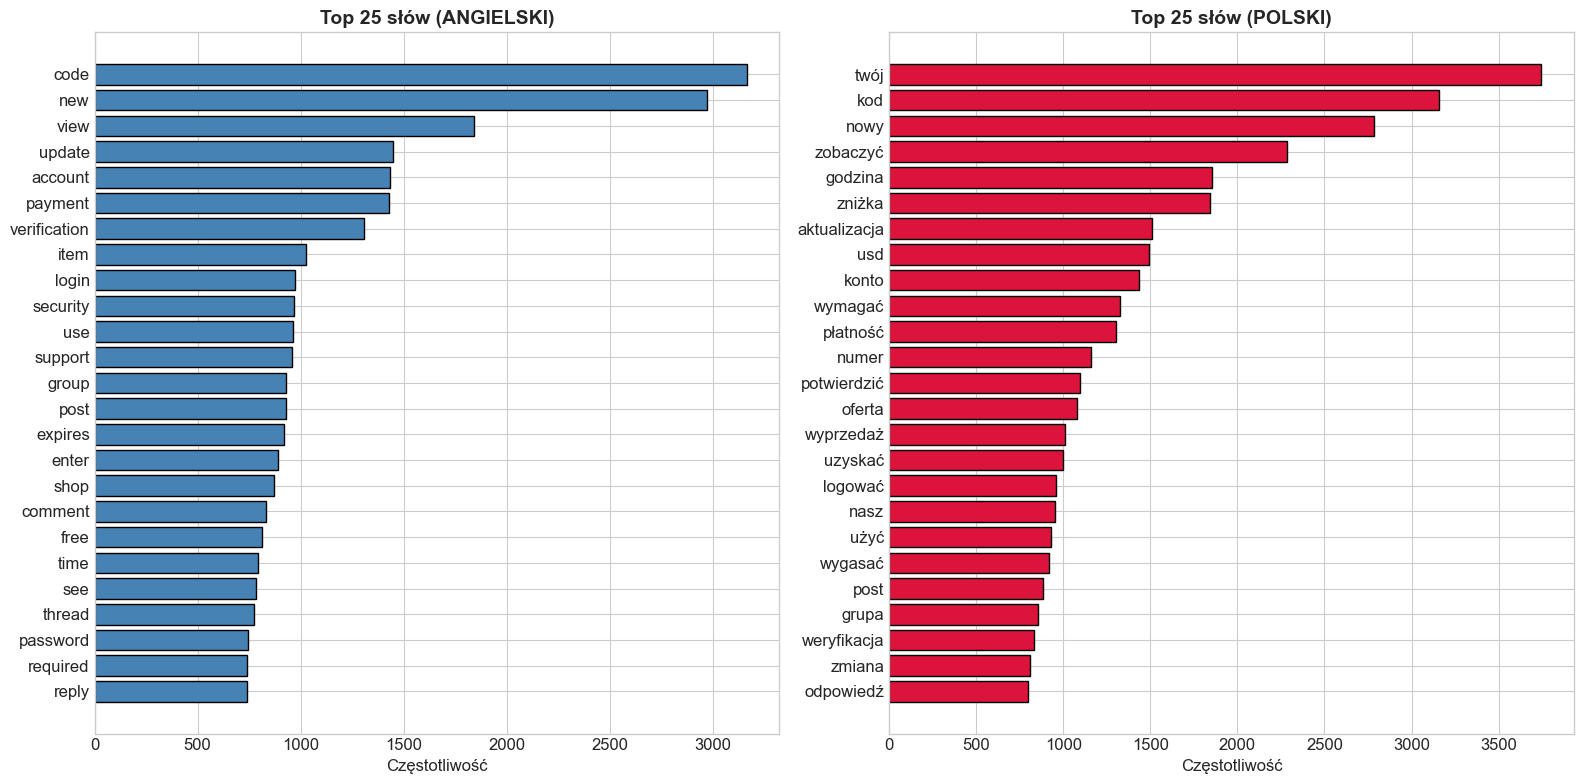


TOP 15 SŁÓW - PORÓWNANIE
 # |         Angielski         |         🇵🇱 Polski        
----------------------------------------------------------------------
 1 |        code (3166)        |        twój (3746)       
 2 |        new (2972)         |        kod (3160)        
 3 |        view (1840)        |        nowy (2785)       
 4 |       update (1451)       |      zobaczyć (2283)     
 5 |      account (1434)       |      godzina (1854)      
 6 |      payment (1431)       |       zniżka (1841)      
 7 |    verification (1306)    |    aktualizacja (1507)   
 8 |        item (1028)        |        usd (1492)        
 9 |        login (974)        |       konto (1432)       
10 |      security (969)       |      wymagać (1326)      
11 |         use (965)         |      płatność (1304)     
12 |       support (956)       |       numer (1158)       
13 |        group (931)        |    potwierdzić (1095)    
14 |        post (927)         |       oferta (1076)      
15 |       expires

In [23]:
# Funkcja do zliczania słów
def get_word_freq(texts, n=20):
    """Zwraca n najczęstszych słów"""
    all_words = ' '.join(texts.dropna()).split()
    return Counter(all_words).most_common(n)

# Top 25 słów - porównanie EN vs PL
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

words_en = get_word_freq(df['text_clean'], 25)
if words_en:
    w_en, c_en = zip(*words_en)
    axes[0].barh(w_en[::-1], c_en[::-1], color='steelblue', edgecolor='black')
    axes[0].set_title('Top 25 słów (ANGIELSKI)', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Częstotliwość')

words_pl = get_word_freq(df_pl['text_clean'], 25)
if words_pl:
    w_pl, c_pl = zip(*words_pl)
    axes[1].barh(w_pl[::-1], c_pl[::-1], color='crimson', edgecolor='black')
    axes[1].set_title('Top 25 słów (POLSKI)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Częstotliwość')

plt.tight_layout()
plt.show()

# Tabela porównawcza
print("\n" + "="*70)
print("TOP 15 SŁÓW - PORÓWNANIE")
print("="*70)
print(f"{'#':>2} | {'Angielski':^25} | {'🇵🇱 Polski':^25}")
print("-"*70)
for i in range(15):
    en_word = f"{words_en[i][0]} ({words_en[i][1]})" if i < len(words_en) else "-"
    pl_word = f"{words_pl[i][0]} ({words_pl[i][1]})" if i < len(words_pl) else "-"
    print(f"{i+1:>2} | {en_word:^25} | {pl_word:^25}")

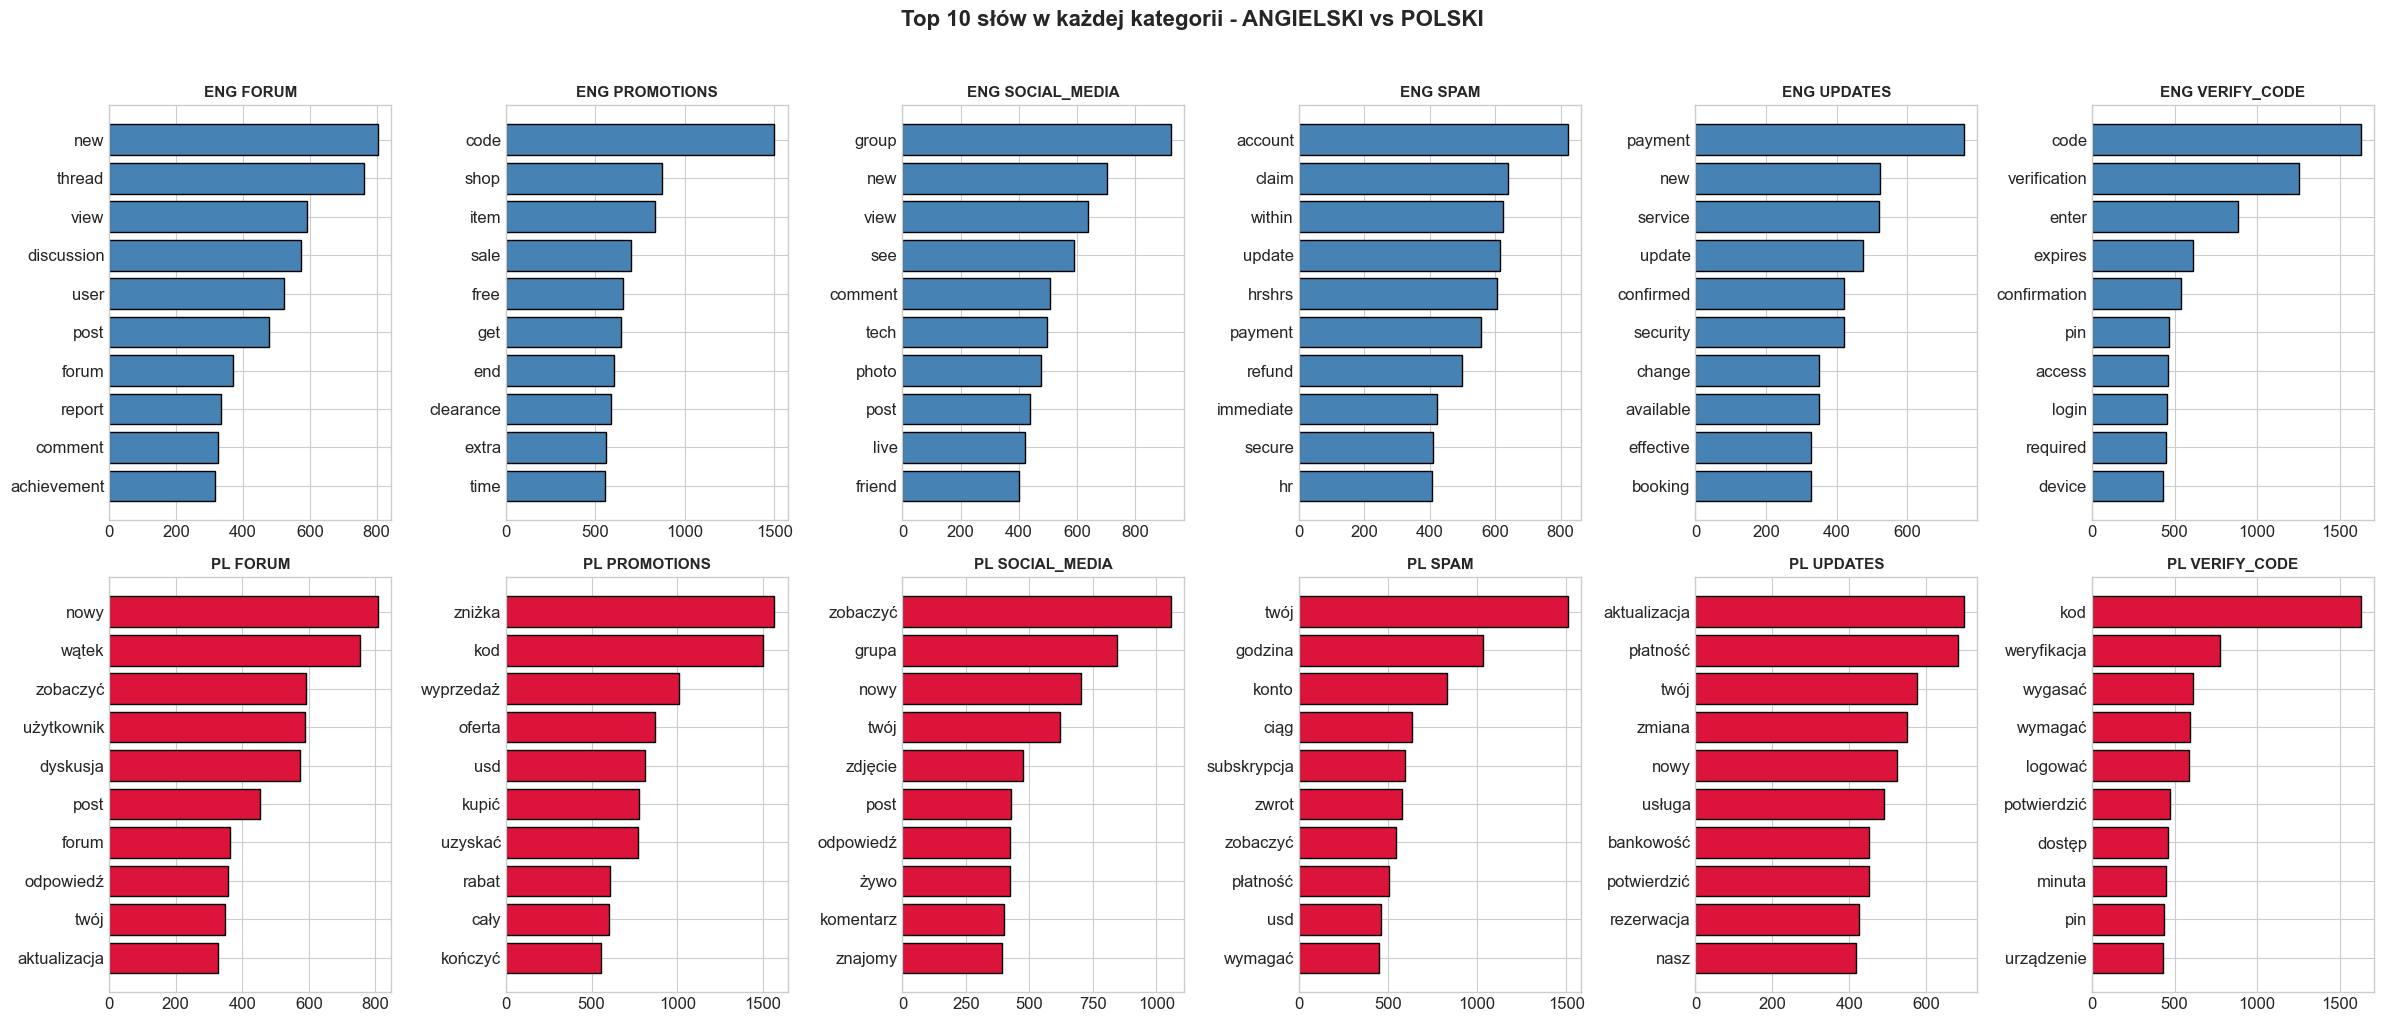

In [24]:
# Top słowa dla każdej kategorii - PORÓWNANIE EN vs PL
categories = df['category'].unique()

category_colors = {
    'forum': '#FF6B6B', 'promotions': '#4ECDC4', 'social_media': '#45B7D1',
    'spam': '#FFEAA7', 'updates': '#96CEB4', 'verify_code': '#DDA0DD'
}

fig, axes = plt.subplots(2, 6, figsize=(24, 10))

for idx, cat in enumerate(sorted(categories)):
    # Angielski (górny rząd)
    cat_texts_en = df[df['category'] == cat]['text_clean']
    top_words_en = get_word_freq(cat_texts_en, 10)
    if top_words_en:
        w, c = zip(*top_words_en)
        axes[0, idx].barh(w[::-1], c[::-1], color='steelblue', edgecolor='black')
        axes[0, idx].set_title(f'ENG {cat.upper()}', fontsize=11, fontweight='bold')

    # Polski (dolny rząd)
    cat_texts_pl = df_pl[df_pl['category'] == cat]['text_clean']
    top_words_pl = get_word_freq(cat_texts_pl, 10)
    if top_words_pl:
        w, c = zip(*top_words_pl)
        axes[1, idx].barh(w[::-1], c[::-1], color='crimson', edgecolor='black')
        axes[1, idx].set_title(f'PL {cat.upper()}', fontsize=11, fontweight='bold')

plt.suptitle('Top 10 słów w każdej kategorii - ANGIELSKI vs POLSKI', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 6. Word Clouds - Chmury słów

Wizualizacja najczęstszych słów w formie chmury dla obu języków:

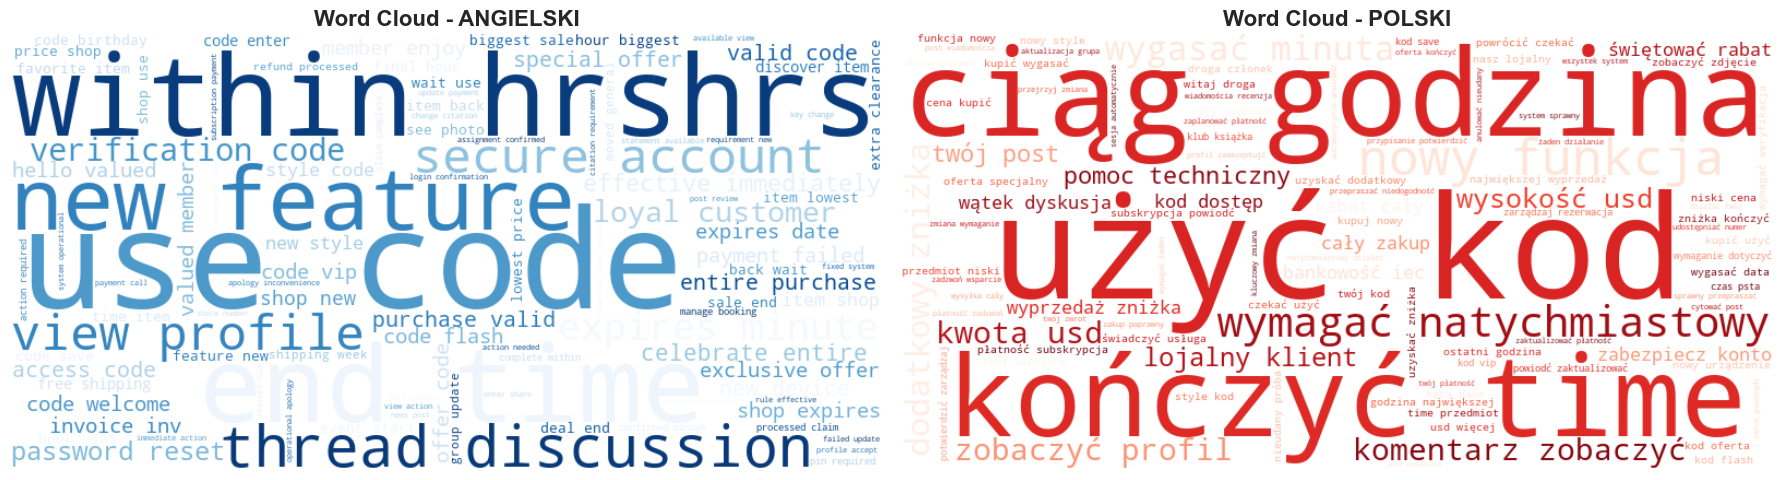

In [25]:
# Word Cloud dla całego zbioru - EN vs PL
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Angielski
all_text_en = ' '.join(df['text_clean'].dropna())
wc_en = WordCloud(width=800, height=400, background_color='white',
                  colormap='Blues', max_words=100).generate(all_text_en)
axes[0].imshow(wc_en, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Word Cloud - ANGIELSKI', fontsize=16, fontweight='bold')

# Polski
all_text_pl = ' '.join(df_pl['text_clean'].dropna())
wc_pl = WordCloud(width=800, height=400, background_color='white',
                  colormap='Reds', max_words=100).generate(all_text_pl)
axes[1].imshow(wc_pl, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('Word Cloud - POLSKI', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

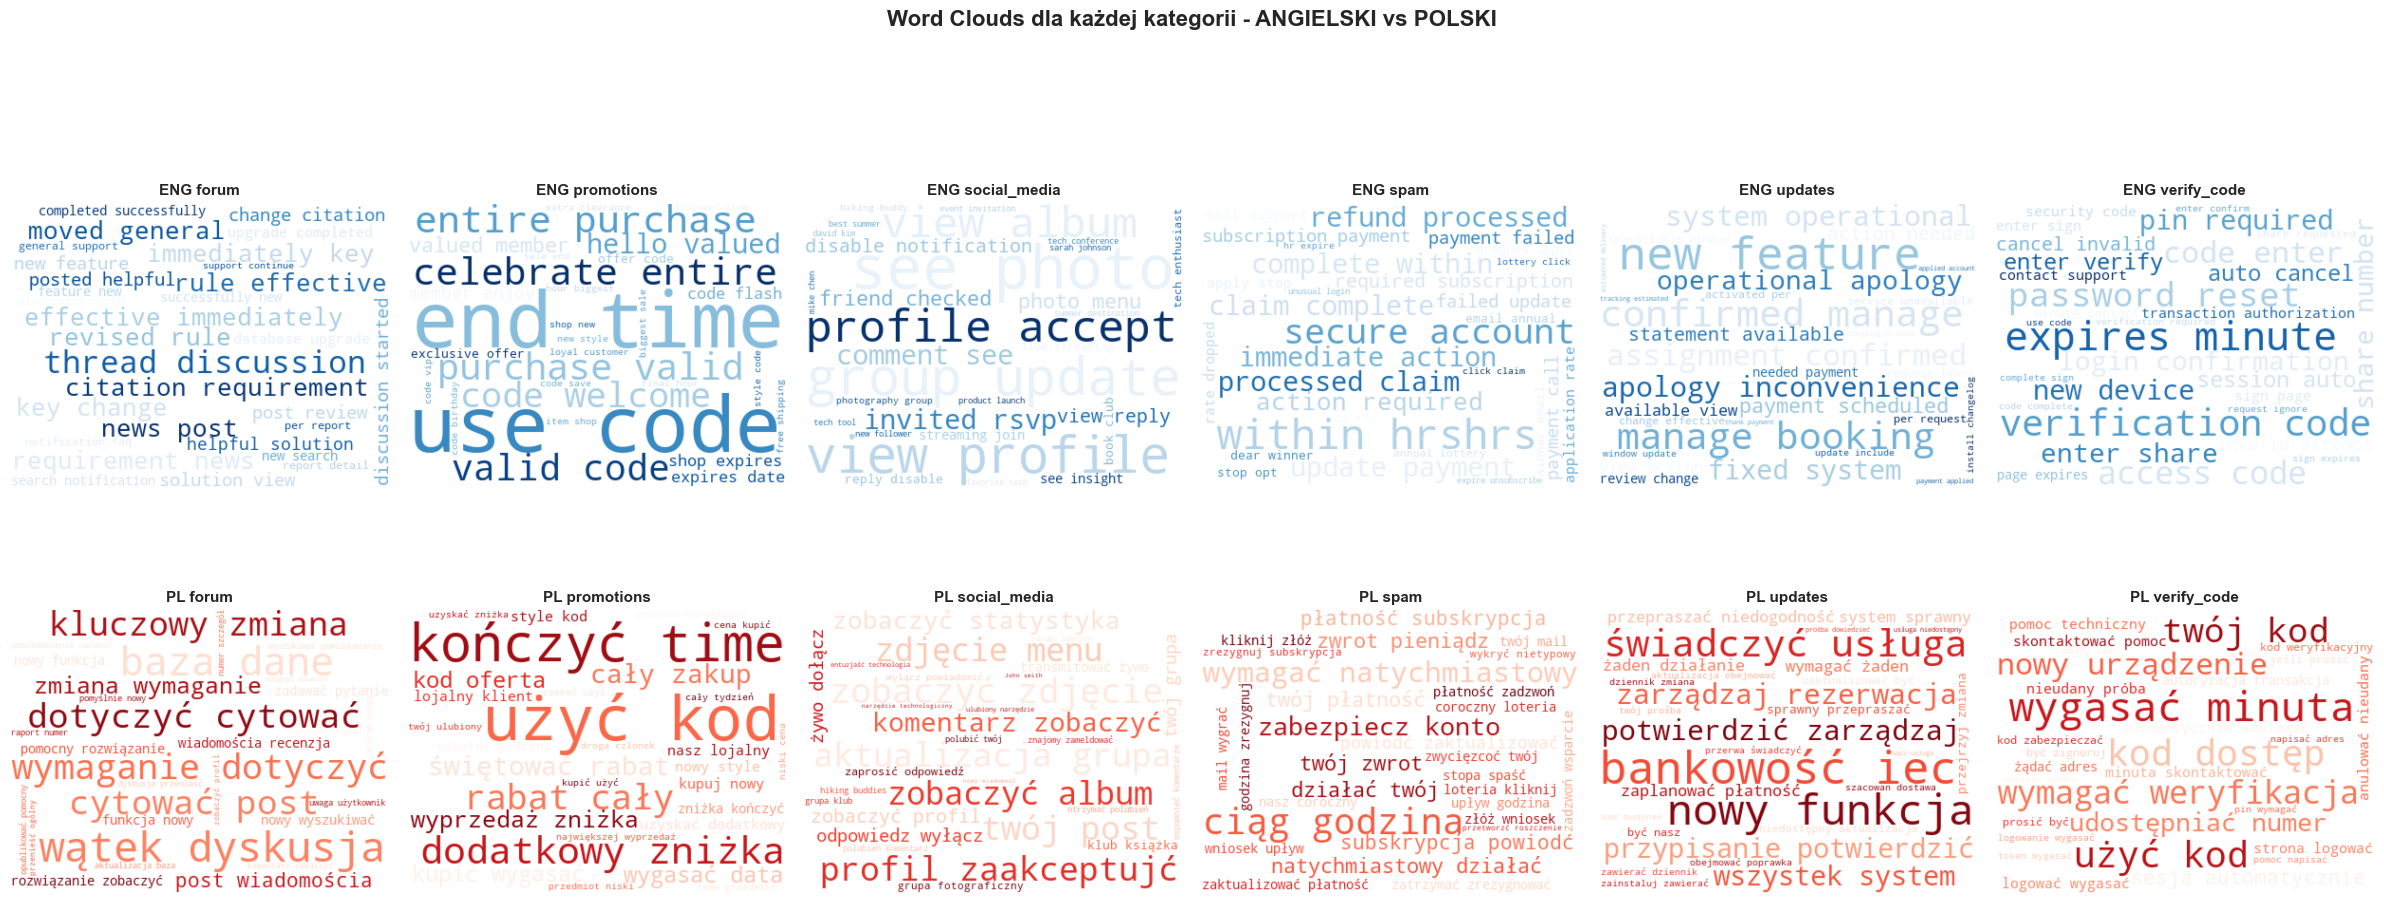

In [26]:
# Word Clouds dla każdej kategorii - EN vs PL (2 rzędy x 6 kategorii)
fig, axes = plt.subplots(2, 6, figsize=(24, 10))

colormap_en = 'Blues'
colormap_pl = 'Reds'

for idx, cat in enumerate(sorted(categories)):
    # Angielski (górny rząd)
    cat_text_en = ' '.join(df[df['category'] == cat]['text_clean'].dropna())
    if cat_text_en.strip():
        wc_en = WordCloud(width=400, height=300, background_color='white',
                          colormap=colormap_en, max_words=30).generate(cat_text_en)
        axes[0, idx].imshow(wc_en, interpolation='bilinear')
    axes[0, idx].set_title(f'ENG {cat}', fontsize=11, fontweight='bold')
    axes[0, idx].axis('off')

    # Polski (dolny rząd)
    cat_text_pl = ' '.join(df_pl[df_pl['category'] == cat]['text_clean'].dropna())
    if cat_text_pl.strip():
        wc_pl = WordCloud(width=400, height=300, background_color='white',
                          colormap=colormap_pl, max_words=30).generate(cat_text_pl)
        axes[1, idx].imshow(wc_pl, interpolation='bilinear')
    axes[1, idx].set_title(f'PL {cat}', fontsize=11, fontweight='bold')
    axes[1, idx].axis('off')

plt.suptitle('Word Clouds dla każdej kategorii - ANGIELSKI vs POLSKI', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 7. Analiza N-gramów

Porównanie bigramów i trigramów w obu językach:

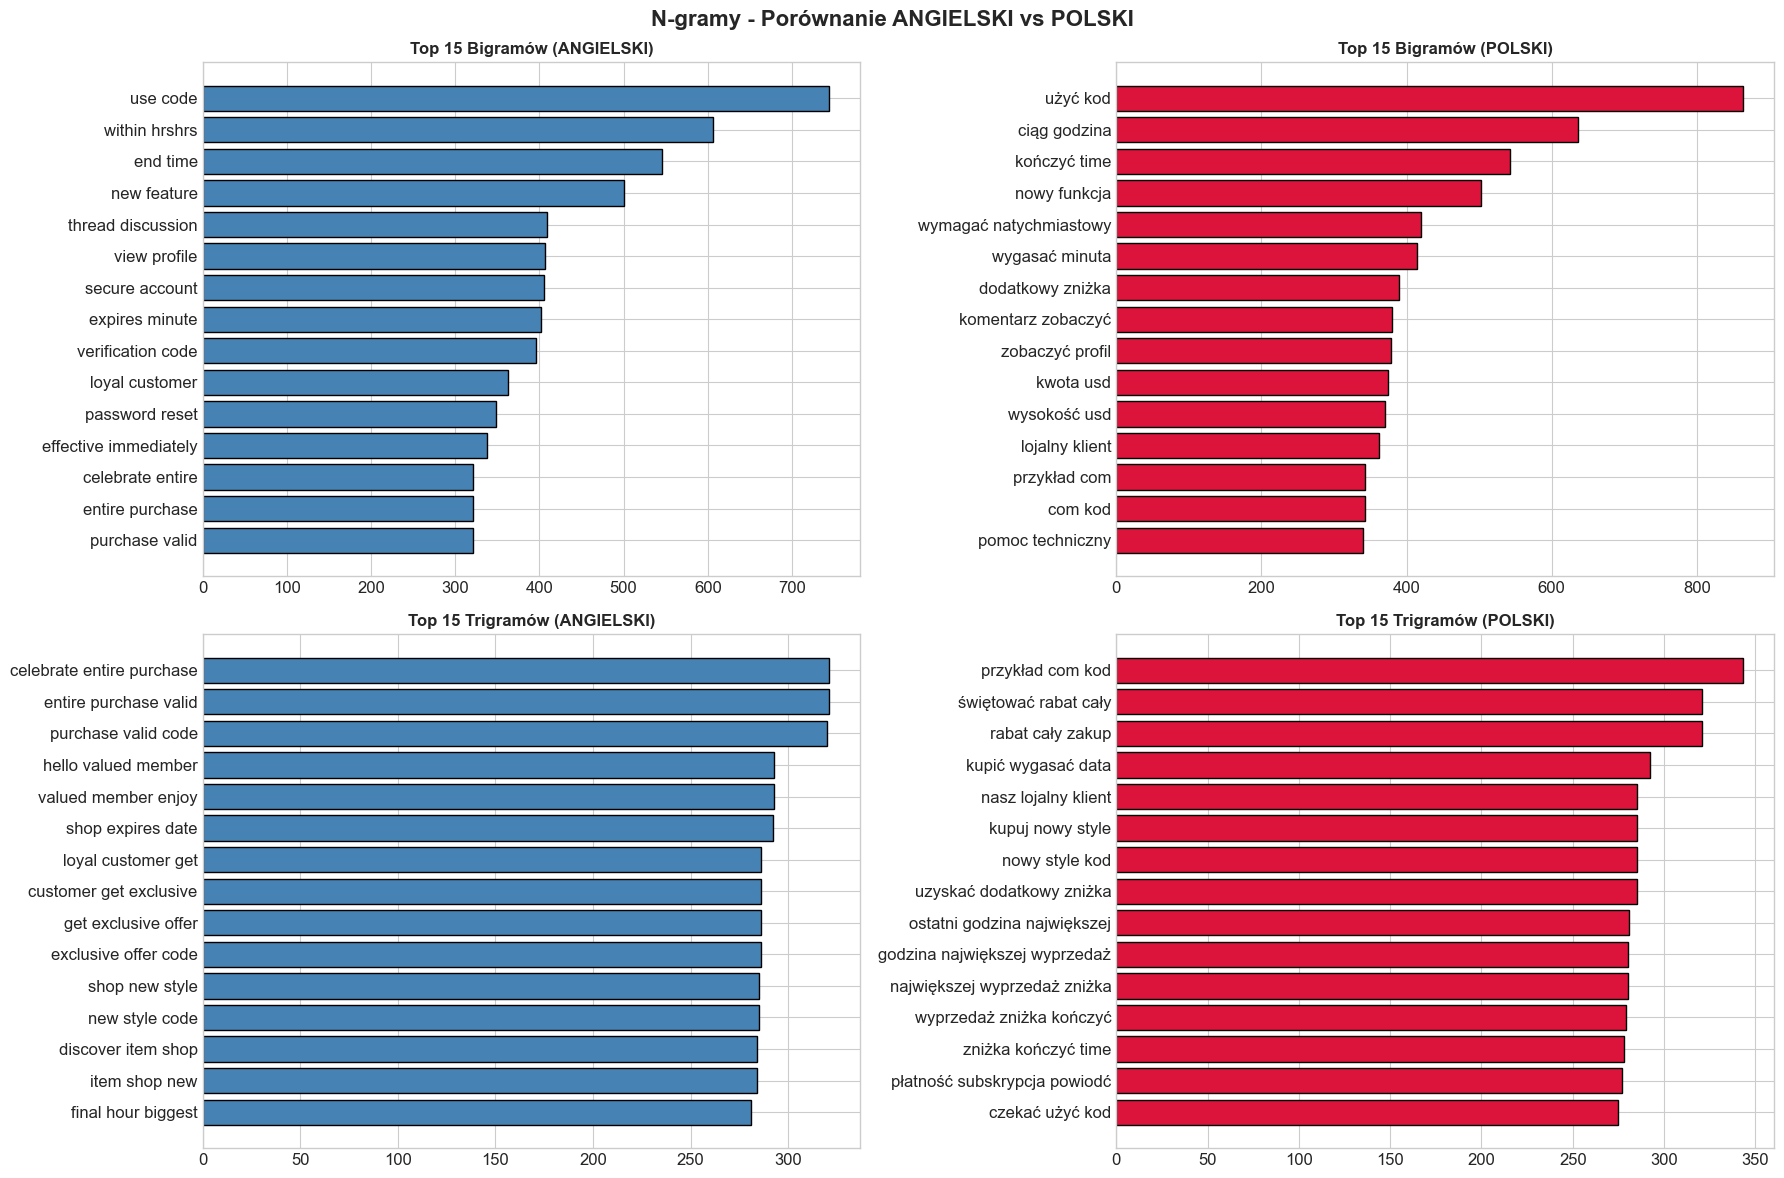

In [27]:
from nltk import ngrams

def get_ngrams(texts, n=2, top=15):
    all_words = ' '.join(texts.dropna()).split()
    n_grams = list(ngrams(all_words, n))
    return Counter(n_grams).most_common(top)

# Bigramy i trigramy - EN vs PL
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Bigramy EN
bigrams_en = get_ngrams(df['text_clean'], 2, 15)
if bigrams_en:
    labels, counts = zip(*[(f'{a} {b}', c) for (a,b), c in bigrams_en])
    axes[0, 0].barh(labels[::-1], counts[::-1], color='steelblue', edgecolor='black')
    axes[0, 0].set_title('Top 15 Bigramów (ANGIELSKI)', fontsize=12, fontweight='bold')

# Bigramy PL
bigrams_pl = get_ngrams(df_pl['text_clean'], 2, 15)
if bigrams_pl:
    labels, counts = zip(*[(f'{a} {b}', c) for (a,b), c in bigrams_pl])
    axes[0, 1].barh(labels[::-1], counts[::-1], color='crimson', edgecolor='black')
    axes[0, 1].set_title('Top 15 Bigramów (POLSKI)', fontsize=12, fontweight='bold')

# Trigramy EN
trigrams_en = get_ngrams(df['text_clean'], 3, 15)
if trigrams_en:
    labels, counts = zip(*[(f'{a} {b} {c}', cnt) for (a,b,c), cnt in trigrams_en])
    axes[1, 0].barh(labels[::-1], counts[::-1], color='steelblue', edgecolor='black')
    axes[1, 0].set_title('Top 15 Trigramów (ANGIELSKI)', fontsize=12, fontweight='bold')

# Trigramy PL
trigrams_pl = get_ngrams(df_pl['text_clean'], 3, 15)
if trigrams_pl:
    labels, counts = zip(*[(f'{a} {b} {c}', cnt) for (a,b,c), cnt in trigrams_pl])
    axes[1, 1].barh(labels[::-1], counts[::-1], color='crimson', edgecolor='black')
    axes[1, 1].set_title('Top 15 Trigramów (POLSKI)', fontsize=12, fontweight='bold')

plt.suptitle('N-gramy - Porównanie ANGIELSKI vs POLSKI', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 8. Analiza TF-IDF

TF-IDF dla obu języków - słowa charakterystyczne dla każdej kategorii:

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Reset indeksów
df_reset = df.reset_index(drop=True)
df_pl_reset = df_pl.reset_index(drop=True)

# TF-IDF dla angielskiego
tfidf_en = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
tfidf_matrix_en = tfidf_en.fit_transform(df_reset['text_clean'].fillna(''))
feature_names_en = np.array(tfidf_en.get_feature_names_out())

# TF-IDF dla polskiego
tfidf_pl = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
tfidf_matrix_pl = tfidf_pl.fit_transform(df_pl_reset['text_clean'].fillna(''))
feature_names_pl = np.array(tfidf_pl.get_feature_names_out())


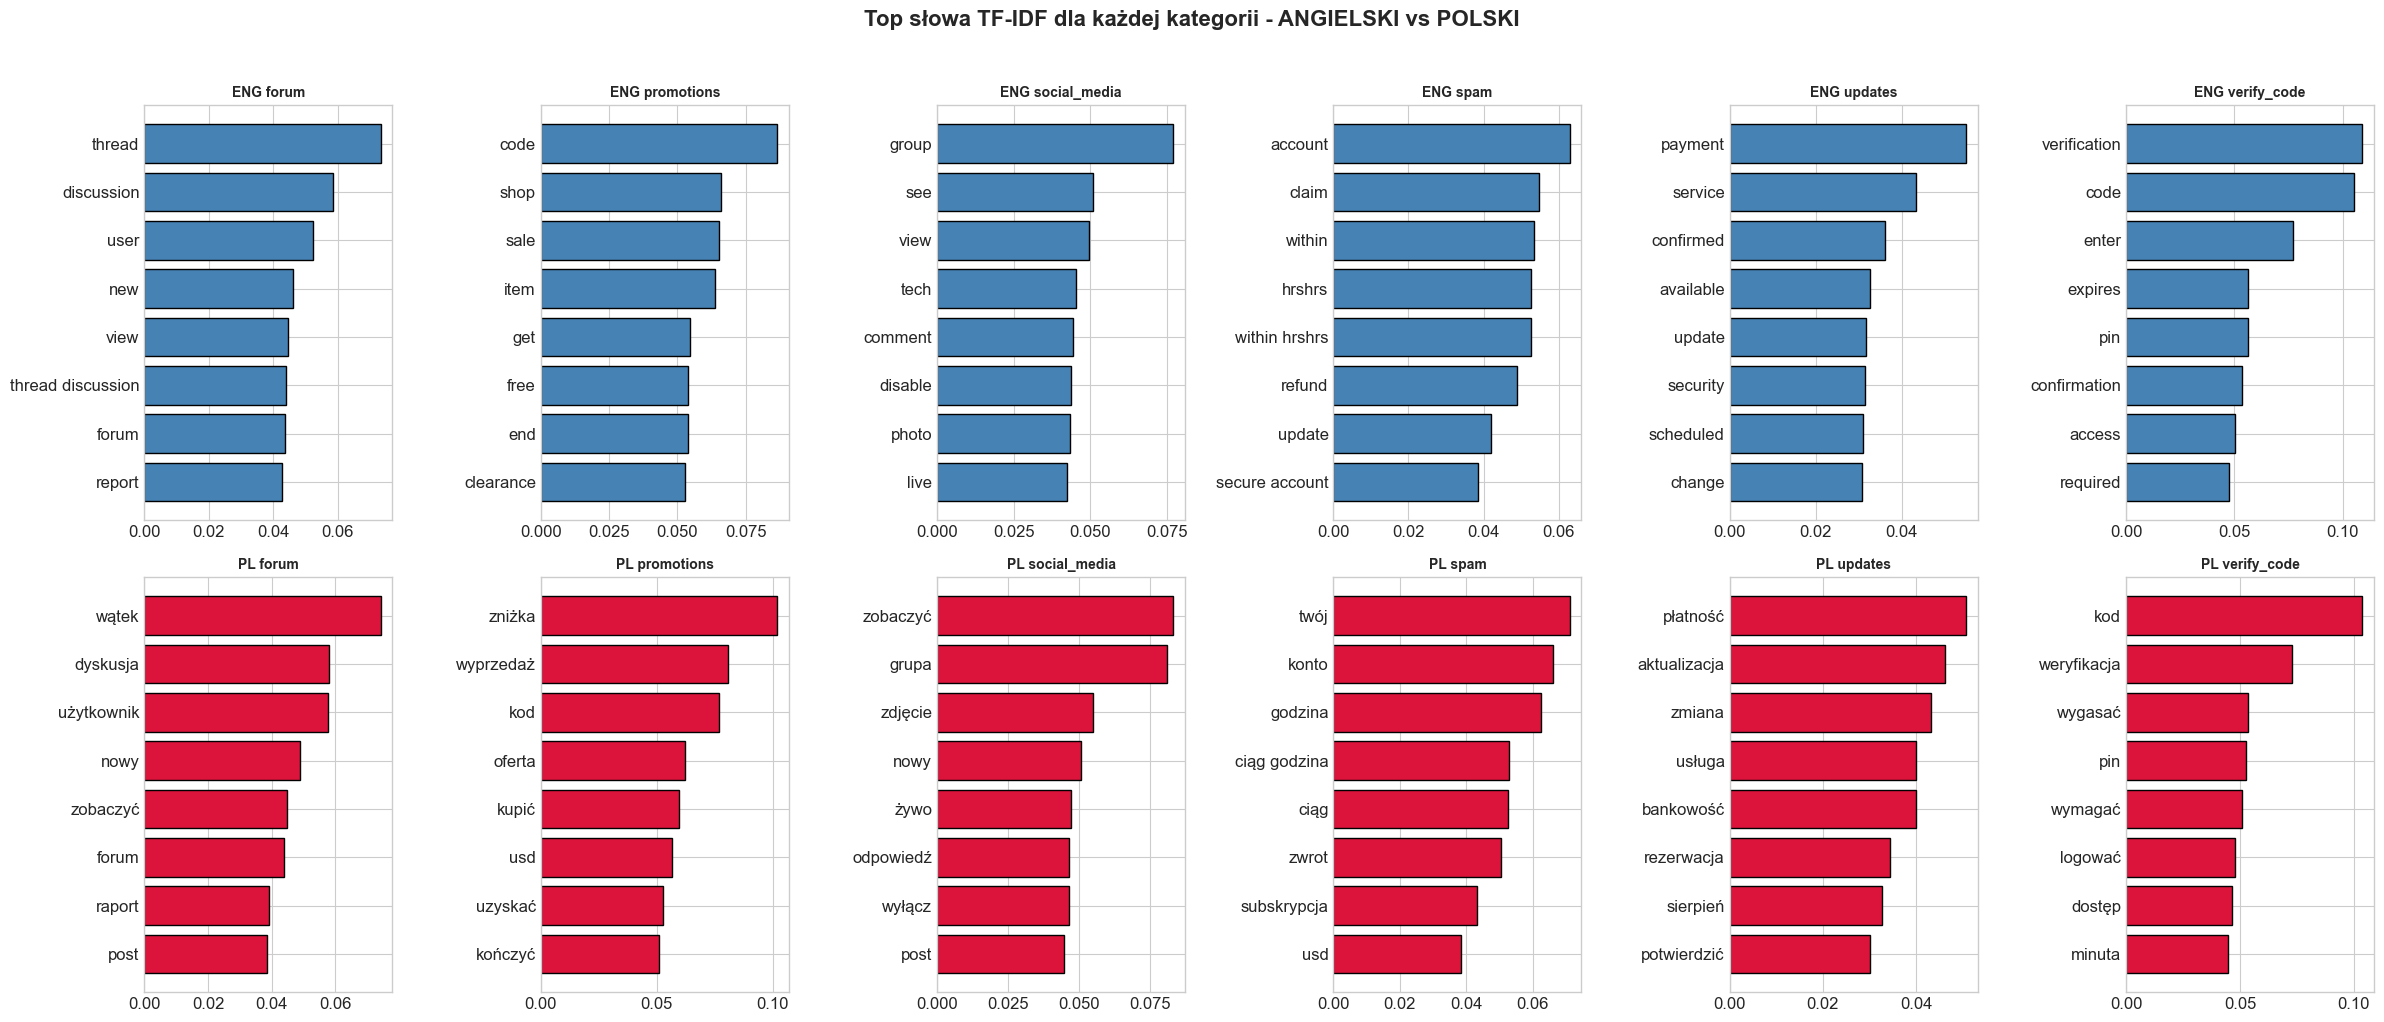

In [29]:
def get_top_tfidf_words(category, tfidf_matrix, feature_names, df_data, n=10):
    """Zwraca top n słów z najwyższym średnim TF-IDF dla kategorii"""
    # DODAJEMY .values na końcu, aby uzyskać tablicę NumPy zamiast Series
    cat_mask = (df_data['category'] == category).values

    # Sprawdzenie, czy kategoria w ogóle istnieje w danych (aby uniknąć błędu przy pustej masce)
    if not cat_mask.any():
        return []

    # Filtrowanie macierzy rzadkiej
    cat_tfidf = tfidf_matrix[cat_mask].mean(axis=0).A1
    top_indices = cat_tfidf.argsort()[-n:][::-1]

    return [(feature_names[i], cat_tfidf[i]) for i in top_indices]

# Wizualizacja TF-IDF EN vs PL
fig, axes = plt.subplots(2, 6, figsize=(24, 10))

for idx, cat in enumerate(sorted(categories)):
    # EN (górny rząd)
    top_en = get_top_tfidf_words(cat, tfidf_matrix_en, feature_names_en, df_reset, 8)
    if top_en:
        words, scores = zip(*top_en)
        axes[0, idx].barh(words[::-1], scores[::-1], color='steelblue', edgecolor='black')
        axes[0, idx].set_title(f'ENG {cat}', fontsize=10, fontweight='bold')

    # PL (dolny rząd)
    top_pl = get_top_tfidf_words(cat, tfidf_matrix_pl, feature_names_pl, df_pl_reset, 8)
    if top_pl:
        words, scores = zip(*top_pl)
        axes[1, idx].barh(words[::-1], scores[::-1], color='crimson', edgecolor='black')
        axes[1, idx].set_title(f'PL {cat}', fontsize=10, fontweight='bold')

plt.suptitle('Top słowa TF-IDF dla każdej kategorii - ANGIELSKI vs POLSKI', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 9. Dodatkowe cechy tekstowe

Analiza dodatkowych charakterystyk tekstu: obecność URLi, cyfr, wielkich liter, znaków specjalnych itp.

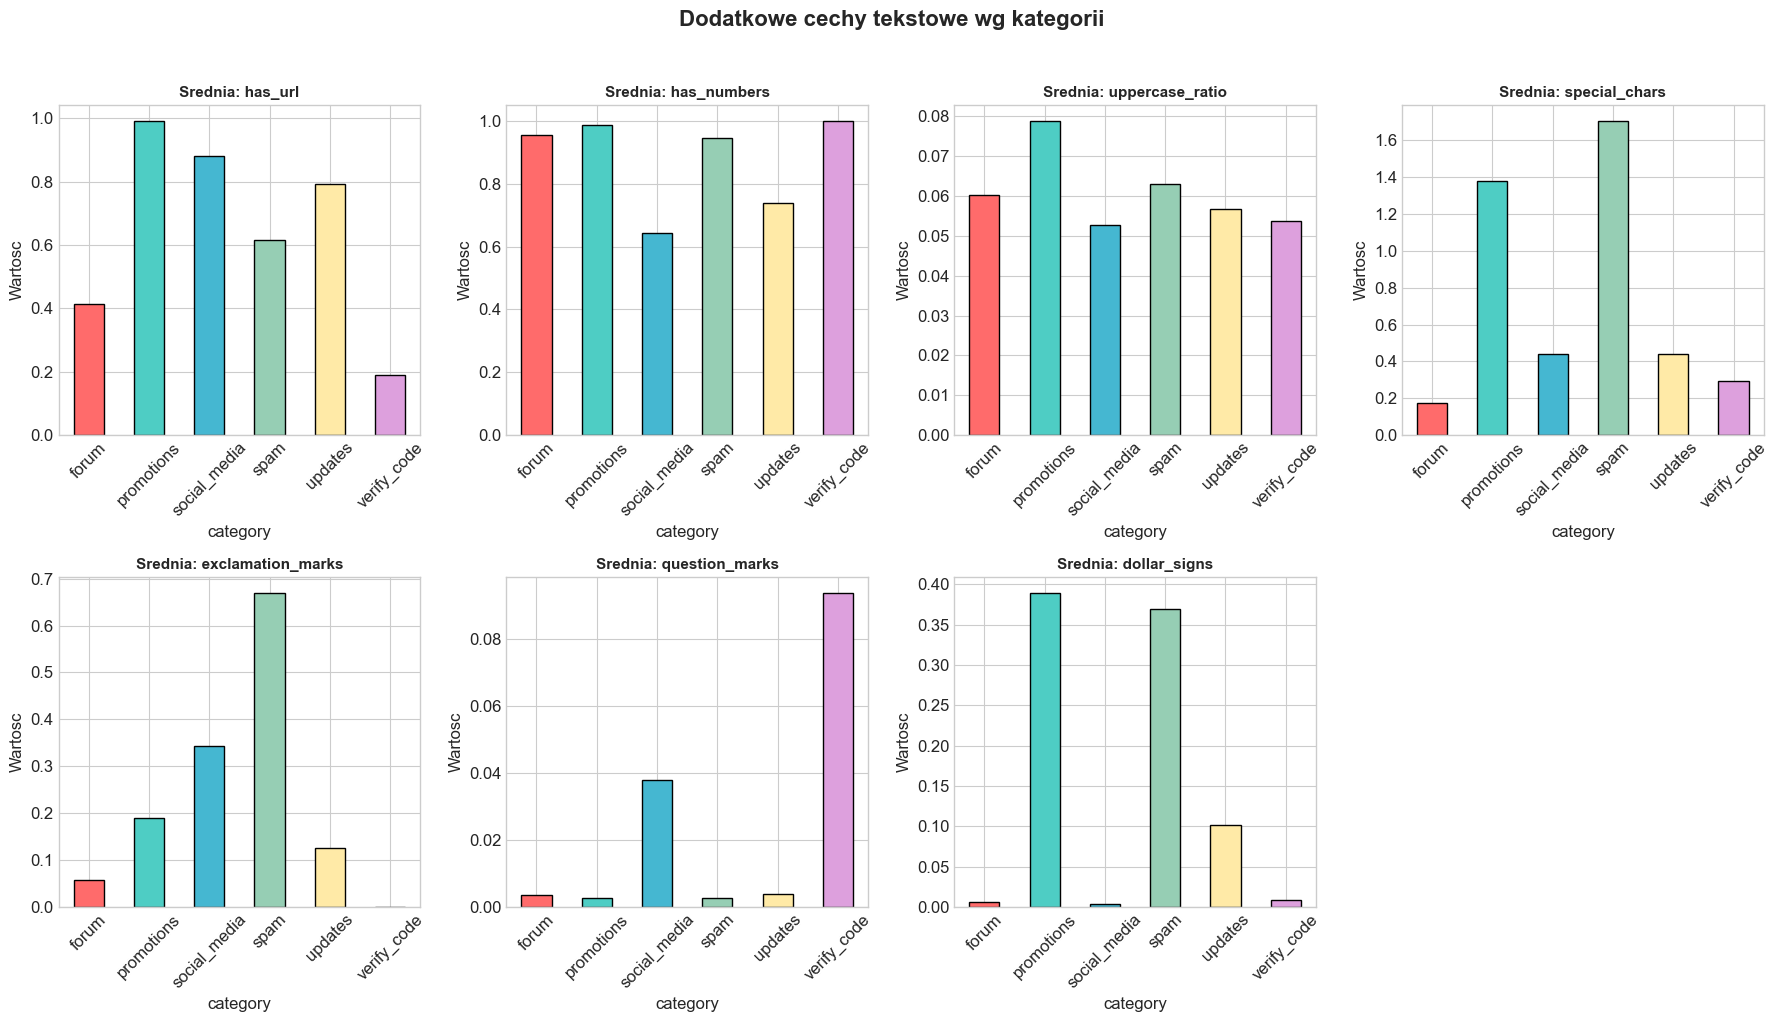


 Srednie wartosci cech per kategoria:
category           forum  promotions  social_media   spam  updates  \
has_url            0.412       0.991         0.880  0.617    0.793   
has_numbers        0.956       0.987         0.644  0.947    0.737   
uppercase_ratio    0.060       0.079         0.053  0.063    0.057   
special_chars      0.175       1.377         0.441  1.704    0.442   
exclamation_marks  0.058       0.189         0.343  0.669    0.127   
question_marks     0.004       0.003         0.038  0.003    0.004   
dollar_signs       0.006       0.389         0.004  0.369    0.102   

category           verify_code  
has_url                  0.190  
has_numbers              1.000  
uppercase_ratio          0.054  
special_chars            0.296  
exclamation_marks        0.000  
question_marks           0.094  
dollar_signs             0.009  


In [30]:
# Ekstrakcja dodatkowych cech
df['has_url'] = df['text'].apply(lambda x: 1 if re.search(r'http|www|\.com', x.lower()) else 0)
df['has_numbers'] = df['text'].apply(lambda x: 1 if re.search(r'\d+', x) else 0)
df['uppercase_ratio'] = df['text'].apply(lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0)
df['special_chars'] = df['text'].apply(lambda x: sum(1 for c in x if c in '!?$%@#&*'))
df['exclamation_marks'] = df['text'].apply(lambda x: x.count('!'))
df['question_marks'] = df['text'].apply(lambda x: x.count('?'))
df['dollar_signs'] = df['text'].apply(lambda x: x.count('$'))

# Wizualizacja cech per kategoria
feature_cols = ['has_url', 'has_numbers', 'uppercase_ratio', 'special_chars',
                'exclamation_marks', 'question_marks', 'dollar_signs']

fig, axes = plt.subplots(2, 4, figsize=(18, 10))
axes = axes.flatten()

for idx, col in enumerate(feature_cols):
    df.groupby('category')[col].mean().plot(kind='bar', ax=axes[idx],
                                             color=colors, edgecolor='black')
    axes[idx].set_title(f'Srednia: {col}', fontsize=11, fontweight='bold')
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].set_ylabel('Wartosc')

# Ukrycie pustego wykresu
axes[-1].axis('off')

plt.suptitle('Dodatkowe cechy tekstowe wg kategorii', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Tabela ze statystykami
print("\n Srednie wartosci cech per kategoria:")
print(df.groupby('category')[feature_cols].mean().round(3).T)

## 10. Mapa korelacji cech

Sprawdźmy jak cechy tekstowe korelują ze sobą:

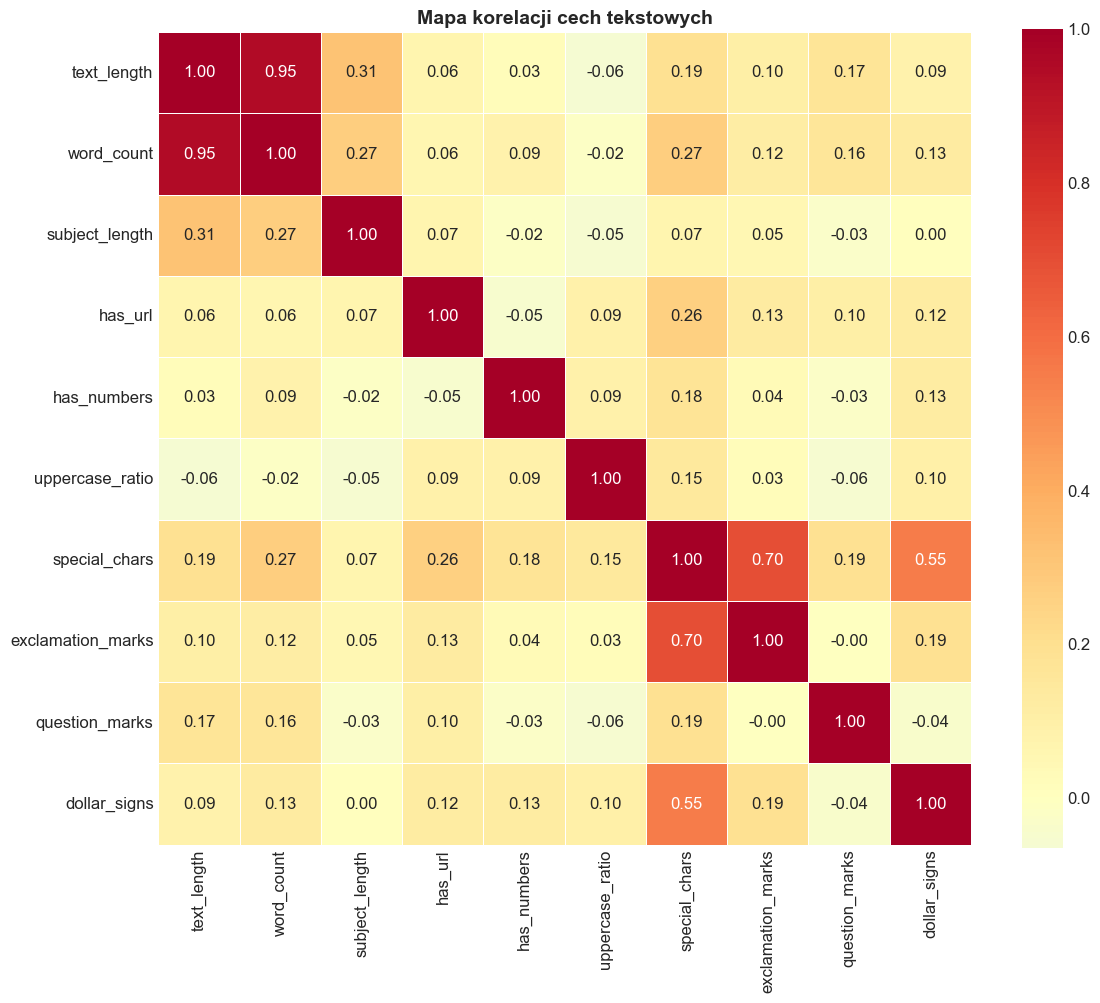

In [31]:
# Korelacja wszystkich cech numerycznych
numeric_cols = ['text_length', 'word_count', 'subject_length', 'has_url',
                'has_numbers', 'uppercase_ratio', 'special_chars',
                'exclamation_marks', 'question_marks', 'dollar_signs']

correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlBu_r', center=0,
            fmt='.2f', square=True, linewidths=0.5)
plt.title('Mapa korelacji cech tekstowych', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 11. Podsumowanie analizy eksploracyjnej

### Główne wnioski z analizy:

In [32]:
# Podsumowanie statystyczne   to się przyda do sprawka, tutaj do wyjebania
print("="*70)
print("             PODSUMOWANIE ANALIZY EKSPLORACYJNEJ")
print("="*70)

print(f"""
 ZBIOR DANYCH:
   - Liczba emaili: {len(df):,}
   - Liczba kategorii: {df['category'].nunique()}
   - Kategorie: {', '.join(df['category'].unique())}

 BALANS KLAS:
   - Zbior jest bardzo dobrze zbalansowany
   - Kazda kategoria ma ok. 2,200-2,250 emaili (~16.7%)

 STATYSTYKI TEKSTOWE:
   - Srednia dlugosc tekstu: {df['text_length'].mean():.0f} znakow
   - Srednia liczba slow: {df['word_count'].mean():.0f}
   - Zakres dlugosci: {df['text_length'].min()} - {df['text_length'].max()} znakow

""")

print("="*70)
print(" PRZETWORZONE DANE GOTOWE DO KLASYFIKACJI!")
print("="*70)

# Zapisanie przetworzonych danych
df.to_csv('emails_preprocessed.csv', index=False)
print("\n Dane zapisane do: emails_preprocessed.csv")

             PODSUMOWANIE ANALIZY EKSPLORACYJNEJ

 ZBIOR DANYCH:
   - Liczba emaili: 13,477
   - Liczba kategorii: 6
   - Kategorie: promotions, spam, social_media, forum, verify_code, updates

 BALANS KLAS:
   - Zbior jest bardzo dobrze zbalansowany
   - Kazda kategoria ma ok. 2,200-2,250 emaili (~16.7%)

 STATYSTYKI TEKSTOWE:
   - Srednia dlugosc tekstu: 125 znakow
   - Srednia liczba slow: 16
   - Zakres dlugosci: 55 - 1947 znakow


 PRZETWORZONE DANE GOTOWE DO KLASYFIKACJI!

 Dane zapisane do: emails_preprocessed.csv


In [33]:
# Podgląd końcowy danych
print("Struktura koncowa DataFrame:")
print(df.info())
print("\n" + "="*50)
print("\nPrzyklad przetworzonego emaila:")
sample = df.iloc[100]
print(f"\nKategoria: {sample['category']}")
print(f"Temat: {sample['subject']}")
print(f"Oryginalny tekst: {sample['text'][:150]}...")
print(f"Po preprocessingu: {sample['text_clean'][:150]}...")
print(f"\nCechy:")
print(f"  - Dlugosc: {sample['text_length']} znakow, {sample['word_count']} slow")
print(f"  - Zawiera URL: {'Tak' if sample['has_url'] else 'Nie'}")
print(f"  - Zawiera liczby: {'Tak' if sample['has_numbers'] else 'Nie'}")
print(f"  - Znaki specjalne: {sample['special_chars']}")

Struktura koncowa DataFrame:
<class 'pandas.core.frame.DataFrame'>
Index: 13477 entries, 0 to 2696
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 13477 non-null  object 
 1   subject            13477 non-null  object 
 2   body               13477 non-null  object 
 3   text               13477 non-null  object 
 4   category           13477 non-null  object 
 5   category_id        13477 non-null  int64  
 6   text_length        13477 non-null  int64  
 7   word_count         13477 non-null  int64  
 8   subject_length     13477 non-null  int64  
 9   text_clean         13477 non-null  object 
 10  has_url            13477 non-null  int64  
 11  has_numbers        13477 non-null  int64  
 12  uppercase_ratio    13477 non-null  float64
 13  special_chars      13477 non-null  int64  
 14  exclamation_marks  13477 non-null  int64  
 15  question_marks     13477 non-null  int64  
 16 

---
# CZĘŚĆ 2: KLASYFIKACJA EMAILI

## 12. Przygotowanie danych do treningu

In [34]:
from sklearn.preprocessing import LabelEncoder

# Podział danych wg oryginalnego podziału
train_indices = list(range(len(dataset['train'])))
test_indices = list(range(len(dataset['train']), len(dataset['train']) + len(dataset['test'])))

# ANGIELSKI
df_train_en = dataset['train'].to_pandas()
df_test_en = dataset['test'].to_pandas()
df_train_en['text_clean'] = df_train_en['text'].apply(preprocess_text_en)
df_test_en['text_clean'] = df_test_en['text'].apply(preprocess_text_en)

# POLSKI
df_train_pl = df_pl.iloc[:len(dataset['train'])].copy()
df_test_pl = df_pl.iloc[len(dataset['train']):].copy()
# Preprocessing już wykonany wcześniej dla df_pl

# Przygotowanie danych
X_train_en = df_train_en['text_clean']
X_test_en = df_test_en['text_clean']
X_train_pl = df_train_pl['text_clean']
X_test_pl = df_test_pl['text_clean']

# Etykiety (te same dla obu języków)
y_train_raw = df_train_en['category']
y_test_raw = df_test_en['category']

# Enkodowanie etykiet
label_encoder = LabelEncoder()
label_encoder.fit(pd.concat([y_train_raw, y_test_raw]))
y_train = label_encoder.transform(y_train_raw)
y_test = label_encoder.transform(y_test_raw)

print(f"\nANGIELSKI: Train={len(X_train_en)}, Test={len(X_test_en)}")
print(f"POLSKI:    Train={len(X_train_pl)}, Test={len(X_test_pl)}")


ANGIELSKI: Train=10780, Test=2697
POLSKI:    Train=10780, Test=2697


In [35]:
X_train_pl[0]

'oferta rocznicowy kupić jeden drugi otrzymać gratis nasz lojalny klient uzyskać ekskluzywny zniżka usd kwota usd więcej kod oferta welcomy'

In [36]:
# Wektoryzacja TF-IDF dla obu języków
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_params = {
    'max_features': 10000,
    'ngram_range': (1, 2),    # Zostawiamy (bardzo ważne dla rozróżnienia 'verify code' vs 'promo code')
    'min_df': 3,              # Ignorujemy słowa występujące rzadziej niż 3 razy (szum)
    'max_df': 0.95,           #  restrykcyjne (usuwa słowa występujące w x% maili)
    'sublinear_tf': True      # Logarytmiczne skalowanie (kluczowe przy mailach o różnej długości)
}

tfidf_en = TfidfVectorizer(**tfidf_params)
X_train_tfidf_en = tfidf_en.fit_transform(X_train_en.fillna(''))
X_test_tfidf_en = tfidf_en.transform(X_test_en.fillna(''))

tfidf_pl_clf = TfidfVectorizer(**tfidf_params)
X_train_tfidf_pl = tfidf_pl_clf.fit_transform(X_train_pl.fillna(''))
X_test_tfidf_pl = tfidf_pl_clf.transform(X_test_pl.fillna(''))

print("="*70)
print("WEKTORYZACJA TF-IDF")
print("="*70)
print(f"\nANGIELSKI:")
print(f"Train: {X_train_tfidf_en.shape}, Test: {X_test_tfidf_en.shape}")
print(f"Liczba cech: {len(tfidf_en.get_feature_names_out())}")
print(f"\nPOLSKI:")
print(f"Train: {X_train_tfidf_pl.shape}, Test: {X_test_tfidf_pl.shape}")
print(f"Liczba cech: {len(tfidf_pl_clf.get_feature_names_out())}")

WEKTORYZACJA TF-IDF

ANGIELSKI:
Train: (10780, 4507), Test: (2697, 4507)
Liczba cech: 4507

POLSKI:
Train: (10780, 6172), Test: (2697, 6172)
Liczba cech: 6172


## 13. Trening modeli klasyfikacji

In [37]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
import time
import warnings
warnings.filterwarnings('ignore')

def train_and_evaluate_models(X_train, X_test, y_train, y_test, lang_name):
    models = {
        'Naive Bayes': MultinomialNB(),
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'Linear SVM': LinearSVC(random_state=42, max_iter=2000),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
        'KNN': KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
    }

    results = {}
    print(f"\n{'='*60}")
    print(f"  {lang_name}")
    print(f"{'='*60}")

    for name, model in models.items():
        start_time = time.time()
        model.fit(X_train, y_train)
        train_time = time.time() - start_time

        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average='weighted')
        rec = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        results[name] = {
            'model': model, 'accuracy': acc, 'precision': prec,
            'recall': rec, 'f1': f1, 'predictions': y_pred, 'train_time': train_time
        }
        # print(f"  {name:<22} Accuracy: {acc:.4f} | F1: {f1:.4f}")

    return results


In [38]:
def display_metrics(results):
    # Wyciągamy metryki ze słownika (bez obiektu modelu i predykcji)
    summary_data = []
    for name, metrics in results.items():
        summary_data.append({
            'Model': name,
            'Accuracy': metrics['accuracy'],
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'F1-Score': metrics['f1'],
            'Train Time (s)': metrics['train_time']
        })

    df_results = pd.DataFrame(summary_data).sort_values(by='F1-Score', ascending=False)

    print("\n" + "="*85)
    print(f"{'PORÓWNANIE MODELI':^85}")
    print("="*85)
    print(df_results.to_string(index=False, formatters={
        'Accuracy': '{:,.4f}'.format,
        'Precision': '{:,.4f}'.format,
        'Recall': '{:,.4f}'.format,
        'F1-Score': '{:,.4f}'.format,
        'Train Time (s)': '{:,.2f}'.format
    }))

    # return df_results

## Trening


In [39]:
results_en = train_and_evaluate_models(X_train_tfidf_en, X_test_tfidf_en, y_train, y_test, "ANGIELSKI")

display_metrics(results_en)


  ANGIELSKI

                                  PORÓWNANIE MODELI                                  
              Model Accuracy Precision Recall F1-Score Train Time (s)
         Linear SVM   0.9867    0.9867 0.9867   0.9867           0.09
Logistic Regression   0.9844    0.9845 0.9844   0.9844           0.16
        Naive Bayes   0.9811    0.9813 0.9811   0.9811           0.00
      Random Forest   0.9803    0.9803 0.9803   0.9803           0.25
                KNN   0.9781    0.9782 0.9781   0.9781           0.00


In [40]:
results_pl = train_and_evaluate_models(X_train_tfidf_pl, X_test_tfidf_pl, y_train, y_test, "POLSKI")

display_metrics(results_pl)


  POLSKI

                                  PORÓWNANIE MODELI                                  
              Model Accuracy Precision Recall F1-Score Train Time (s)
         Linear SVM   0.9852    0.9852 0.9852   0.9852           0.09
Logistic Regression   0.9800    0.9800 0.9800   0.9800           0.22
        Naive Bayes   0.9766    0.9767 0.9766   0.9767           0.00
      Random Forest   0.9763    0.9763 0.9763   0.9763           0.27
                KNN   0.9711    0.9712 0.9711   0.9711           0.00


## 14. Porównanie modeli

In [41]:
model_names = list(results_en.keys())

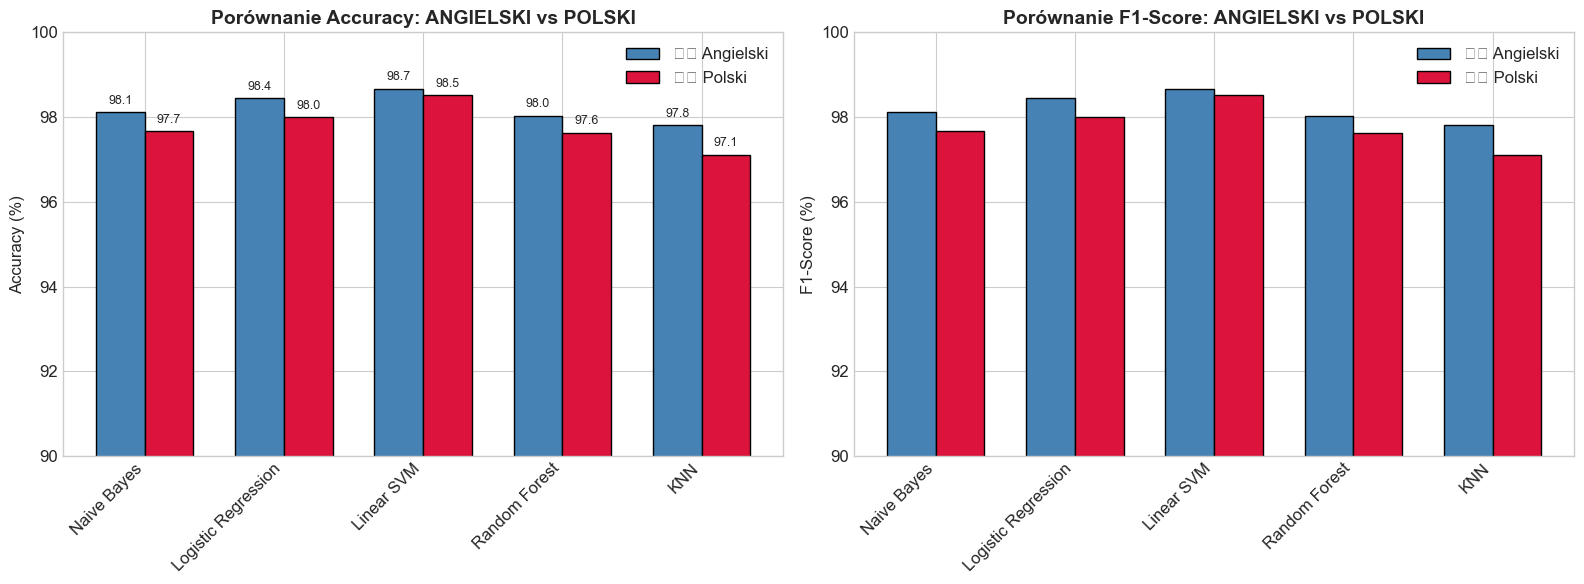

In [42]:
# Porównanie Accuracy EN vs PL
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

acc_en = [results_en[m]['accuracy'] * 100 for m in model_names]
acc_pl = [results_pl[m]['accuracy'] * 100 for m in model_names]

x = np.arange(len(model_names))
width = 0.35

# Accuracy porównanie
bars1 = axes[0].bar(x - width/2, acc_en, width, label='🇬🇧 Angielski', color='steelblue', edgecolor='black')
bars2 = axes[0].bar(x + width/2, acc_pl, width, label='🇵🇱 Polski', color='crimson', edgecolor='black')
axes[0].set_ylim([90, 100])
axes[0].set_ylabel('Accuracy (%)')
axes[0].set_title('Porównanie Accuracy: ANGIELSKI vs POLSKI', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(model_names, rotation=45, ha='right')
axes[0].legend()

for bar in bars1:
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
                 f'{bar.get_height():.1f}', ha='center', fontsize=9)
for bar in bars2:
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
                 f'{bar.get_height():.1f}', ha='center', fontsize=9)

# F1-Score porównanie
f1_en = [results_en[m]['f1'] * 100 for m in model_names]
f1_pl = [results_pl[m]['f1'] * 100 for m in model_names]

bars3 = axes[1].bar(x - width/2, f1_en, width, label='🇬🇧 Angielski', color='steelblue', edgecolor='black')
bars4 = axes[1].bar(x + width/2, f1_pl, width, label='🇵🇱 Polski', color='crimson', edgecolor='black')
axes[1].set_ylim([90, 100])
axes[1].set_ylabel('F1-Score (%)')
axes[1].set_title('Porównanie F1-Score: ANGIELSKI vs POLSKI', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(model_names, rotation=45, ha='right')
axes[1].legend()

plt.tight_layout()
plt.show()

In [43]:
# Tabela porównawcza
print("\n" + "="*80)
print("TABELA PORÓWNAWCZA WYNIKÓW")
print("="*80)
print(f"{'Model':<22} {'Acc 🇬🇧':>10} {'Acc 🇵🇱':>10} {'Δ':>8} {'F1 🇬🇧':>10} {'F1 🇵🇱':>10}")
print("-"*80)
for name in model_names:
    diff = (results_en[name]['accuracy'] - results_pl[name]['accuracy']) * 100
    print(f"{name:<22} {results_en[name]['accuracy']*100:>9.2f}% {results_pl[name]['accuracy']*100:>9.2f}% {diff:>+7.2f} {results_en[name]['f1']*100:>9.2f}% {results_pl[name]['f1']*100:>9.2f}%")

# Najlepsze modele
best_en = max(results_en.keys(), key=lambda x: results_en[x]['accuracy'])
best_pl = max(results_pl.keys(), key=lambda x: results_pl[x]['accuracy'])
print("-"*80)
print(f"\nNAJLEPSZY MODEL 🇬🇧: {best_en} ({results_en[best_en]['accuracy']*100:.2f}%)")
print(f"NAJLEPSZY MODEL 🇵🇱: {best_pl} ({results_pl[best_pl]['accuracy']*100:.2f}%)")


TABELA PORÓWNAWCZA WYNIKÓW
Model                      Acc 🇬🇧     Acc 🇵🇱        Δ      F1 🇬🇧      F1 🇵🇱
--------------------------------------------------------------------------------
Naive Bayes                98.11%     97.66%   +0.44     98.11%     97.67%
Logistic Regression        98.44%     98.00%   +0.44     98.44%     98.00%
Linear SVM                 98.67%     98.52%   +0.15     98.67%     98.52%
Random Forest              98.03%     97.63%   +0.41     98.03%     97.63%
KNN                        97.81%     97.11%   +0.70     97.81%     97.11%
--------------------------------------------------------------------------------

NAJLEPSZY MODEL 🇬🇧: Linear SVM (98.67%)
NAJLEPSZY MODEL 🇵🇱: Linear SVM (98.52%)


## 15. Macierz pomyłek

Porównanie macierzy pomyłek dla najlepszych modeli w obu językach:

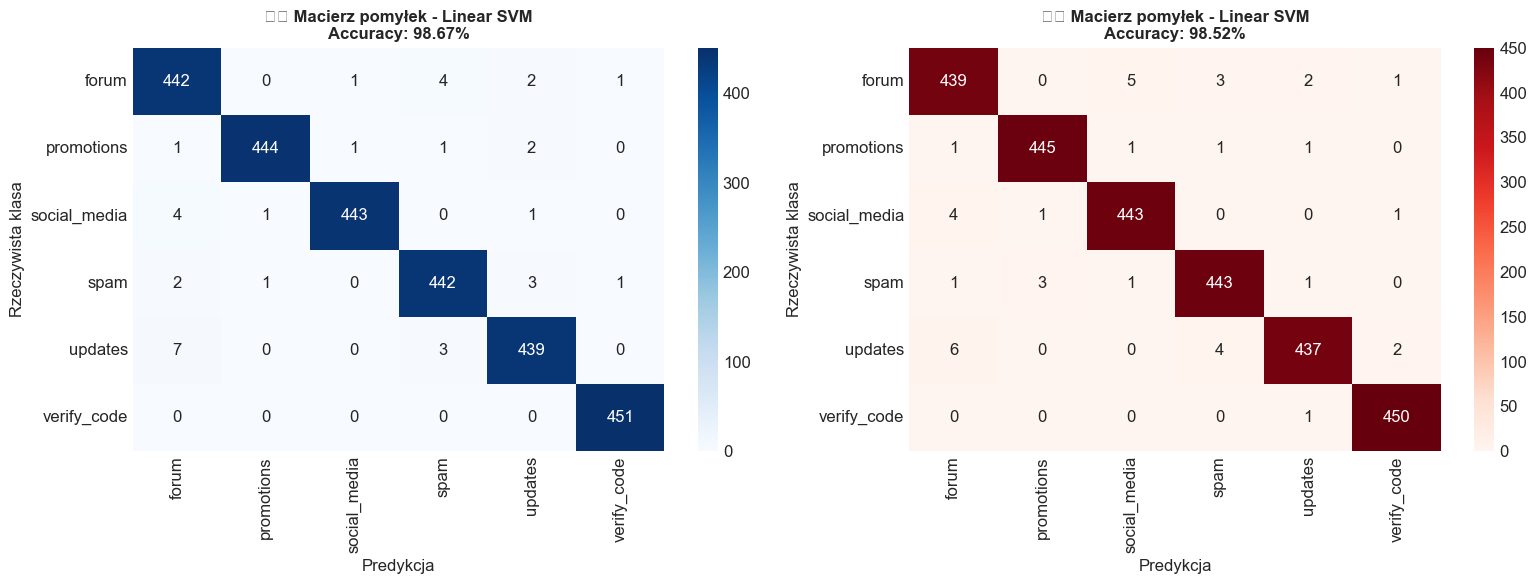


Liczba błędów:
Angielski: 36/2697 (1.33%)
Polski:    40/2697 (1.48%)


In [44]:
# Macierz pomyłek dla najlepszych modeli - EN vs PL
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Angielski
cm_en = confusion_matrix(y_test, results_en[best_en]['predictions'])
sns.heatmap(cm_en, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_, ax=axes[0])
axes[0].set_title(f'🇬🇧 Macierz pomyłek - {best_en}\nAccuracy: {results_en[best_en]["accuracy"]*100:.2f}%',
                  fontsize=12, fontweight='bold')
axes[0].set_xlabel('Predykcja')
axes[0].set_ylabel('Rzeczywista klasa')

# Polski
cm_pl = confusion_matrix(y_test, results_pl[best_pl]['predictions'])
sns.heatmap(cm_pl, annot=True, fmt='d', cmap='Reds',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_, ax=axes[1])
axes[1].set_title(f'🇵🇱 Macierz pomyłek - {best_pl}\nAccuracy: {results_pl[best_pl]["accuracy"]*100:.2f}%',
                  fontsize=12, fontweight='bold')
axes[1].set_xlabel('Predykcja')
axes[1].set_ylabel('Rzeczywista klasa')

plt.tight_layout()
plt.show()

# Liczba błędów
errors_en = (y_test != results_en[best_en]['predictions']).sum()
errors_pl = (y_test != results_pl[best_pl]['predictions']).sum()
print(f"\nLiczba błędów:")
print(f"Angielski: {errors_en}/{len(y_test)} ({errors_en/len(y_test)*100:.2f}%)")
print(f"Polski:    {errors_pl}/{len(y_test)} ({errors_pl/len(y_test)*100:.2f}%)")

CLASSIFICATION REPORT - ANGIELSKI (Linear SVM)
              precision    recall  f1-score   support

       forum       0.97      0.98      0.98       450
  promotions       1.00      0.99      0.99       449
social_media       1.00      0.99      0.99       449
        spam       0.98      0.98      0.98       449
     updates       0.98      0.98      0.98       449
 verify_code       1.00      1.00      1.00       451

    accuracy                           0.99      2697
   macro avg       0.99      0.99      0.99      2697
weighted avg       0.99      0.99      0.99      2697


CLASSIFICATION REPORT - POLSKI (Linear SVM)
              precision    recall  f1-score   support

       forum       0.97      0.98      0.97       450
  promotions       0.99      0.99      0.99       449
social_media       0.98      0.99      0.99       449
        spam       0.98      0.99      0.98       449
     updates       0.99      0.97      0.98       449
 verify_code       0.99      1.00      0

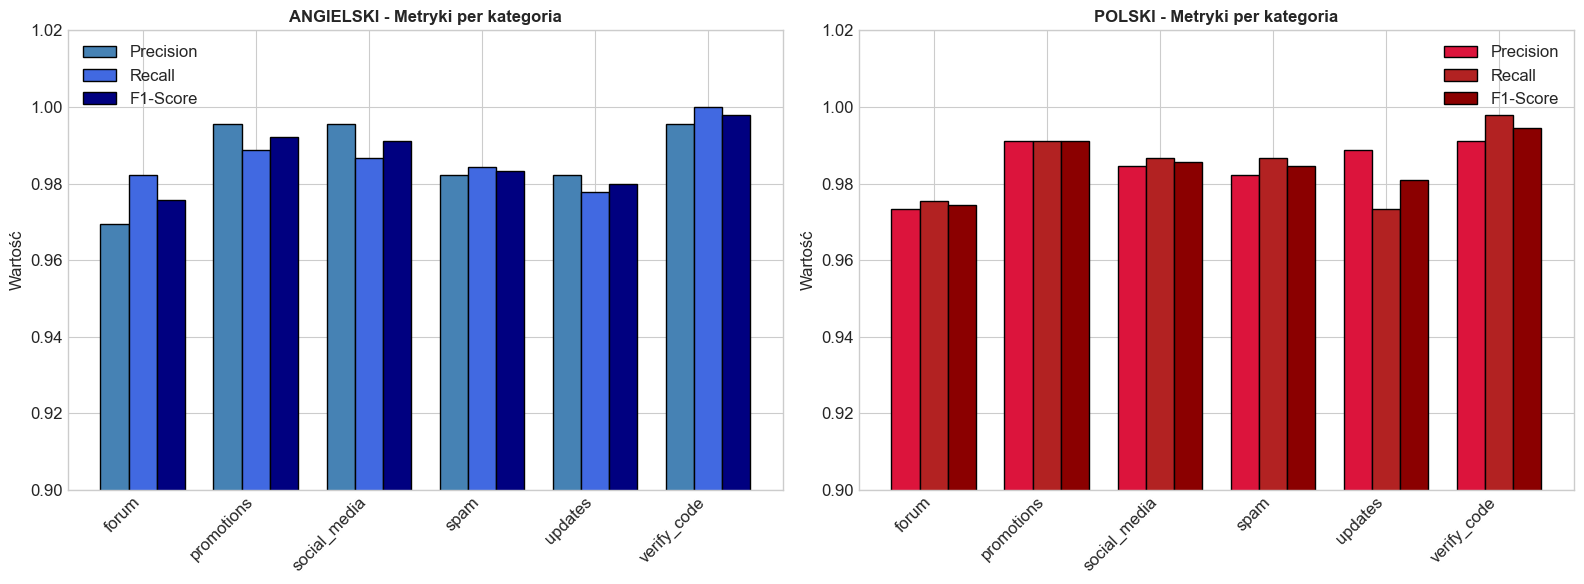

In [45]:
# Classification Report dla obu języków
print("="*80)
print(f"CLASSIFICATION REPORT - ANGIELSKI ({best_en})")
print("="*80)
print(classification_report(y_test, results_en[best_en]['predictions'],
                            target_names=label_encoder.classes_))

print("\n" + "="*80)
print(f"CLASSIFICATION REPORT - POLSKI ({best_pl})")
print("="*80)
print(classification_report(y_test, results_pl[best_pl]['predictions'],
                            target_names=label_encoder.classes_))

# Wizualizacja metryk per klasa - porównanie
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

report_en = classification_report(y_test, results_en[best_en]['predictions'],
                                  target_names=label_encoder.classes_, output_dict=True)
report_pl = classification_report(y_test, results_pl[best_pl]['predictions'],
                                  target_names=label_encoder.classes_, output_dict=True)

cats = list(label_encoder.classes_)
x = np.arange(len(cats))
width = 0.25

for ax, report, title, cmap in [(axes[0], report_en, 'ANGIELSKI', ['steelblue', 'royalblue', 'navy']),
                                  (axes[1], report_pl, 'POLSKI', ['crimson', 'firebrick', 'darkred'])]:
    prec = [report[c]['precision'] for c in cats]
    rec = [report[c]['recall'] for c in cats]
    f1 = [report[c]['f1-score'] for c in cats]

    ax.bar(x - width, prec, width, label='Precision', color=cmap[0], edgecolor='black')
    ax.bar(x, rec, width, label='Recall', color=cmap[1], edgecolor='black')
    ax.bar(x + width, f1, width, label='F1-Score', color=cmap[2], edgecolor='black')
    ax.set_ylim([0.9, 1.02])
    ax.set_ylabel('Wartość')
    ax.set_title(f'{title} - Metryki per kategoria', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(cats, rotation=45, ha='right')
    ax.legend()

plt.tight_layout()
plt.show()

## 16. Analiza błędów

In [46]:

# Błędy angielski
errors_idx_en = np.where(y_test != results_en[best_en]['predictions'])[0]
# Błędy polski
errors_idx_pl = np.where(y_test != results_pl[best_pl]['predictions'])[0]

# Przykłady błędów z obu języków
y_test_labels = label_encoder.inverse_transform(y_test)
y_pred_labels_en = label_encoder.inverse_transform(results_en[best_en]['predictions'])
y_pred_labels_pl = label_encoder.inverse_transform(results_pl[best_pl]['predictions'])

print("\n" + "-"*80)
print("Przykłady błędów 🇬🇧 ANGIELSKI:")
print("-"*80)
for i, idx in enumerate(errors_idx_en[:3]):
    print(f"\n  Błąd #{i+1}: Rzeczywista={y_test_labels[idx]}, Predykcja={y_pred_labels_en[idx]}")
    print(f"  Tekst: {X_test_en.iloc[idx][:80]}...")

print("\n" + "-"*80)
print("Przykłady błędów 🇵🇱 POLSKI:")
print("-"*80)
for i, idx in enumerate(errors_idx_pl[:3]):
    print(f"\n  Błąd #{i+1}: Rzeczywista={y_test_labels[idx]}, Predykcja={y_pred_labels_pl[idx]}")
    print(f"  Tekst: {X_test_pl.iloc[idx][:80]}...")


--------------------------------------------------------------------------------
Przykłady błędów 🇬🇧 ANGIELSKI:
--------------------------------------------------------------------------------

  Błąd #1: Rzeczywista=forum, Predykcja=verify_code
  Tekst: two factor authentication enforcement notice required account dec setup guide au...

  Błąd #2: Rzeczywista=updates, Predykcja=forum
  Tekst: incident report published service outage post mortem analysis sep disruption roo...

  Błąd #3: Rzeczywista=updates, Predykcja=forum
  Tekst: endangered language archive migration complete unesco intangible heritage collec...

--------------------------------------------------------------------------------
Przykłady błędów 🇵🇱 POLSKI:
--------------------------------------------------------------------------------

  Błąd #1: Rzeczywista=forum, Predykcja=verify_code
  Tekst: powiadomieć egzekwować uwierzytelniać dwuskładnikowy wymagać przypadek wszystek ...

  Błąd #2: Rzeczywista=updates, Predyk

## 17. Test modelu na nowych przykładach

Przetestujmy modele na nowych emailach w obu językach:

In [47]:
# Funkcje do klasyfikacji nowych emaili
def classify_email_en(text, model, vectorizer):
    clean_text = preprocess_text_en(text)
    text_vector = vectorizer.transform([clean_text])
    prediction = model.predict(text_vector)[0]
    return label_encoder.inverse_transform([prediction])[0]

def classify_email_pl(text, model, vectorizer):
    clean_text = preprocess_text_pl(text)
    text_vector = vectorizer.transform([clean_text])
    prediction = model.predict(text_vector)[0]
    return label_encoder.inverse_transform([prediction])[0]

# Przykładowe emaile do testowania - EN i PL
test_emails = [
    ("Congratulations! You won $1,000,000! Click here to claim your prize!",
     "Gratulacje! Wygrałeś 1 000 000 zł! Kliknij tutaj, aby odebrać nagrodę!"),

    ("Your verification code is 847291. This code expires in 10 minutes.",
     "Twój kod weryfikacyjny to 847291. Kod wygasa za 10 minut."),

    ("Sarah tagged you in a new photo. See what your friends are up to!",
     "Sara oznaczyła Cię na nowym zdjęciu. Zobacz, co robią Twoi znajomi!"),

    ("Flash Sale! 50% off all items! Use code SAVE50 at checkout.",
     "Błyskawiczna wyprzedaż! 50% zniżki na wszystko! Użyj kodu SAVE50."),

    ("New reply to your thread about Python libraries for machine learning.",
     "Nowa odpowiedź w Twoim wątku o bibliotekach Pythona do uczenia maszynowego.")
]

print("="*80)
print("TEST MODELI NA NOWYCH EMAILACH")
print("="*80)

best_model_en = results_en[best_en]['model']
best_model_pl = results_pl[best_pl]['model']

for i, (email_en, email_pl) in enumerate(test_emails, 1):
    cat_en = classify_email_en(email_en, best_model_en, tfidf_en)
    cat_pl = classify_email_pl(email_pl, best_model_pl, tfidf_pl_clf)

    print(f"\nTest #{i}:")
    print(f"EN: {email_en[:60]}...")
    print(f"   → Predykcja: {cat_en.upper()}")
    print(f"PL: {email_pl[:60]}...")
    print(f"   → Predykcja: {cat_pl.upper()}")
    match = "✅" if cat_en == cat_pl else "⚠️ RÓŻNICA"
    print(f"   {match}")
    print("-"*80)

TEST MODELI NA NOWYCH EMAILACH

Test #1:
EN: Congratulations! You won $1,000,000! Click here to claim you...
   → Predykcja: SPAM
PL: Gratulacje! Wygrałeś 1 000 000 zł! Kliknij tutaj, aby odebra...
   → Predykcja: SPAM
   ✅
--------------------------------------------------------------------------------

Test #2:
EN: Your verification code is 847291. This code expires in 10 mi...
   → Predykcja: VERIFY_CODE
PL: Twój kod weryfikacyjny to 847291. Kod wygasa za 10 minut....
   → Predykcja: VERIFY_CODE
   ✅
--------------------------------------------------------------------------------

Test #3:
EN: Sarah tagged you in a new photo. See what your friends are u...
   → Predykcja: SOCIAL_MEDIA
PL: Sara oznaczyła Cię na nowym zdjęciu. Zobacz, co robią Twoi z...
   → Predykcja: SOCIAL_MEDIA
   ✅
--------------------------------------------------------------------------------

Test #4:
EN: Flash Sale! 50% off all items! Use code SAVE50 at checkout....
   → Predykcja: PROMOTIONS
PL: Błyskawiczna

## 18. Podsumowanie projektu

In [48]:
# to też do wyjebania później
print("="*80)
print("PODSUMOWANIE PROJEKTU KLASYFIKACJI EMAILI 🇬🇧🇵🇱")
print("="*80)

total_emails = len(df)
print(f"""
📁 ZBIÓR DANYCH:
   - Źródło: HuggingFace (jason23322/high-accuracy-email-classifier)
   - Liczba emaili: {total_emails:,}
   - Kategorie: {', '.join(label_encoder.classes_)}
   - Podział: {len(X_train_en):,} train / {len(X_test_en):,} test

🔄 PREPROCESSING:
   - 🇬🇧 Angielski: NLTK (tokenizacja, lematyzacja WordNet, stop words)
   - 🇵🇱 Polski: spaCy pl_core_news_sm (lematyzacja, polskie stop words)
   - Wektoryzacja: TF-IDF

📈 WYNIKI KLASYFIKACJI:
""")

print(f"   {'Model':<22} {'🇬🇧 Accuracy':>14} {'🇵🇱 Accuracy':>14} {'Różnica':>10}")
print("   " + "-"*65)
for name in results_en.keys():
    acc_en_val = results_en[name]['accuracy']*100
    acc_pl_val = results_pl[name]['accuracy']*100
    diff = acc_en_val - acc_pl_val
    print(f"   {name:<22} {acc_en_val:>13.2f}% {acc_pl_val:>13.2f}% {diff:>+9.2f}")

print(f"""

🏆 NAJLEPSZE MODELE:
   - 🇬🇧 Angielski: {best_en} ({results_en[best_en]['accuracy']*100:.2f}%)
   - 🇵🇱 Polski:    {best_pl} ({results_pl[best_pl]['accuracy']*100:.2f}%)

📊 LICZBA BŁĘDÓW:
   - 🇬🇧 Angielski: {len(errors_idx_en)}/{len(y_test)} ({len(errors_idx_en)/len(y_test)*100:.2f}%)
   - 🇵🇱 Polski:    {len(errors_idx_pl)}/{len(y_test)} ({len(errors_idx_pl)/len(y_test)*100:.2f}%)

💡 WNIOSKI:
   - Oba modele osiągają bardzo wysoką dokładność (>98%)
   - Tłumaczenie na polski minimalnie wpływa na wyniki
   - Linear SVM najlepiej sprawdza się dla obu języków
   - Kategoria verify_code najłatwiejsza do klasyfikacji (100%)
   - Modele gotowe do produkcyjnego użycia!

📚 PRZEDMIOT: Eksploracja Danych Tekstowych
""")
print("="*80)

PODSUMOWANIE PROJEKTU KLASYFIKACJI EMAILI 🇬🇧🇵🇱

📁 ZBIÓR DANYCH:
   - Źródło: HuggingFace (jason23322/high-accuracy-email-classifier)
   - Liczba emaili: 13,477
   - Kategorie: forum, promotions, social_media, spam, updates, verify_code
   - Podział: 10,780 train / 2,697 test

🔄 PREPROCESSING:
   - 🇬🇧 Angielski: NLTK (tokenizacja, lematyzacja WordNet, stop words)
   - 🇵🇱 Polski: spaCy pl_core_news_sm (lematyzacja, polskie stop words)
   - Wektoryzacja: TF-IDF

📈 WYNIKI KLASYFIKACJI:

   Model                     🇬🇧 Accuracy    🇵🇱 Accuracy    Różnica
   -----------------------------------------------------------------
   Naive Bayes                    98.11%         97.66%     +0.44
   Logistic Regression            98.44%         98.00%     +0.44
   Linear SVM                     98.67%         98.52%     +0.15
   Random Forest                  98.03%         97.63%     +0.41
   KNN                            97.81%         97.11%     +0.70


🏆 NAJLEPSZE MODELE:
   - 🇬🇧 Angielski: Linea

## 19. Zapis modelu do pliku

Zapisujemy najlepszy model (polski) do użycia w aplikacji:

In [50]:
import pickle

# Zapisujemy OBA modele (polski i angielski)
models_data = {
    'polish': {
        'model': results_pl[best_pl]['model'],
        'vectorizer': tfidf_pl_clf,
        'label_encoder': label_encoder,
        'model_name': best_pl,
        'accuracy': results_pl[best_pl]['accuracy'],
        'language': 'pl'
    },
    'english': {
        'model': results_en[best_en]['model'],
        'vectorizer': tfidf_en,
        'label_encoder': label_encoder,
        'model_name': best_en,
        'accuracy': results_en[best_en]['accuracy'],
        'language': 'en'
    }
}

# Zapisz do pliku
model_filename = 'email_classifier_model.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(models_data, f)

print(f"✅ Modele zapisane do: {model_filename}")
print(f"\n🇵🇱 Polski:")
print(f"   Model: {best_pl}")
print(f"   Accuracy: {results_pl[best_pl]['accuracy']*100:.2f}%")
print(f"\n🇬🇧 Angielski:")
print(f"   Model: {best_en}")
print(f"   Accuracy: {results_en[best_en]['accuracy']*100:.2f}%")
print("\n💡 Możesz teraz użyć obu modeli w aplikacji - wybierz język!")


✅ Modele zapisane do: email_classifier_model.pkl

🇵🇱 Polski:
   Model: Linear SVM
   Accuracy: 98.52%

🇬🇧 Angielski:
   Model: Linear SVM
   Accuracy: 98.67%

💡 Możesz teraz użyć obu modeli w aplikacji - wybierz język!
